### BASIC

In [60]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

# Environment Class
class customDiscreteDistanceBoundarySpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customDiscreteDistanceBoundarySpatialEnv, self).__init__()
        # Steps
        self.current_step = 0
        self.max_step = 1000

        # Base Variables
        self.minimum_distance = 10
        self.padded_boundary = 5
        self.contour_distance = 5

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        
        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}

        # Observation space
        self.observation_space = spaces.Dict(
            {
            "Coordinates" : spaces.Box(low=-1, high=10, shape=(self.maximum_planting_spots, 6), dtype=np.int64),
            "Density": spaces.Box(low=0, high=1, shape=(3,1), dtype=np.float32)
            }
        )
        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([10, 10, 3])
    
   
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])

            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break
        
        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_coordinate_boundary_ratio(self, xcoord:int, ycoord:int):
        """
        Function to generate the x and y ratio of the coordinate to the boundary from the left and top

        Args:
            xcoord (int): x coordinate of planting spot
            ycoord (int): y coordinate of planting spot

        Returns:
            (ratio_x, ratio_y) (tuple)
        """
        boundary = [] #[xleft, xright, ytop, ybottom]

        # Checking x coordinate ratio
        for x in range(xcoord, -1, -1): 
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x == 0:
                boundary.append(x)
        
        for x in range(xcoord, self.grid_size[0]):
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x  == (self.grid_size[0] - 1):
                boundary.append(x)

        # Checking y coordinate ratio
        for y in range(ycoord, -1, -1): 
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == 0:
                boundary.append(y)
        
        for y in range(ycoord, self.grid_size[1]):
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == (self.grid_size[1] - 1):
                boundary.append(y)

        try:
            # Retrieve ratio
            x_length = max(boundary[1] - boundary[0], 1)
            ratio_x = int(round((xcoord-boundary[0]) / x_length, 4)*10)
            
            y_length = max(boundary[3] - boundary[2], 1)
            ratio_y = int(round((ycoord-boundary[2]) / y_length, 4)*10)
            return (ratio_x, ratio_y)
        except:
            print(boundary, xcoord, ycoord)


    def _get_contours(self, xcoord:int, ycoord:int):
        grid_distance = distance_transform_edt(self.filled_boundary)
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0) 
        if chosen_contour <= 1:
            near_boundary = 1
        else:
            near_boundary = 0       
        return near_boundary, round(coordinate_distance, 4)


    def _get_near_curve(self, curve_distance:dict, ratio_list:list):
        # Assume all are curves
        boundary_list = [1] * len(ratio_list)

        for value_list in curve_distance.values():
            # No duplicates
            if len(value_list) <= 1:
                continue
            # Multiple coordinate with same distance
            else:
                seen_x = set()
                seen_y = set()
                for x, y in value_list:
                    # Check if vertically or horizontally aligned coordinates have the same distance, if yes likely in a straight line
                    if x in seen_x or y in seen_y:
                        ratio_index = ratio_list.index((x,y))
                        boundary_list[ratio_index] = 0
                    seen_x.add(x)
                    seen_y.add(y)
                
        return boundary_list


    def _embed_coordinates(self, planting_coordinates:np.ndarray, num_plants:int):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        curve_distance = {}
        ratio_list = []

        # Padded
        normalised_planting_list = np.full((num_plants, 6), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            ratio_coords = self._get_coordinate_boundary_ratio(planting_coords[1], planting_coords[0])
            contour_value, contour_dist = self._get_contours(planting_coords[1], planting_coords[0])
            # Update distance in the distance dictionary 
            distance_coord_list = curve_distance.get(contour_dist, [])
            distance_coord_list.append((ratio_coords[0], ratio_coords[1]))
            curve_distance[contour_dist] = distance_coord_list
            ratio_list.append((ratio_coords[0], ratio_coords[1]))
            # Update data
            normalised_planting_list[i] = ratio_coords + (contour_value, 0) + (1, 0)
            self.obv_planting_coordinates[i] = (planting_coords[1], planting_coords[0])
        
        boundary_list = self._get_near_curve(curve_distance, ratio_list)
        normalised_planting_list[:len(boundary_list), 3] = boundary_list
        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return {
            "Coordinates": self.normalised_planting_list,
            "Density": np.array(list(self.class_density.values())).reshape(3,1).astype(np.float32)
        }


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        return self._get_observation() , {}


    def step(self, action):
        self.current_step += 1
        reward = 0

        # Decode action
        x_ratio = action[0]
        y_ratio = action[1]
        class_value = action[2]

        chosen_index = self._retrieve_closest_coordinate(x_ratio, y_ratio)
        if chosen_index == -1:
            reward = 0

        else: 
            # Update grid, class count and planting list to now be planted
            chosen_value = self.normalised_planting_list[chosen_index]
            chosen_coordinates = self.obv_planting_coordinates[chosen_index]
            self.grid[chosen_coordinates[1], chosen_coordinates[0]] = class_value + 2
            self.class_count[class_value] += 1
            self.normalised_planting_list[chosen_index][-1] = 1

            # Tree Logic
            if class_value == 0:
                self.tree_coordinates.append((chosen_coordinates[1], chosen_coordinates[0]))

                # Tree Plantable
                if class_value == 0 and chosen_value[-2] == 1:
                    reward += 1

                # Location of planting
                if chosen_value[-3] == 1 and chosen_value[-4] == 1:
                    reward += 2

                elif chosen_value[-4] == 1: # Near Boundary
                    reward += 1

                elif chosen_value[-3] == 1: # Near Curve but not near boundary
                    reward += 1
                
                else:
                    reward += 0

                # Update plantable
                self._update_tree_distance()

            # Shrub Logic
            elif class_value == 1:
                if chosen_value[-4] == 0: # Nearer to boundary, penalise
                    reward += 1
                else: # Nearer to center, reward
                    reward += 0
            
            # NA Logic
            else:
                if chosen_value[-4] == 1: # Nearer to boundary, reward
                    reward += 1
                else:
                    reward += 0

            # Check plant density
            density_reward = self._calculate_density_reward(class_value)
            reward += density_reward

            # if self.current_step > 200:
            #     reward -= 1/10* (self.current_step-200)
            
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -1], [1, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), reward, done ,False, {}


    def _retrieve_closest_coordinate(self, xratio:int, yratio:int):
        # Pick the closest plantable coordinate
        filtered_data = self.normalised_planting_list[
            ((self.normalised_planting_list[:, 0].astype(int) == xratio) &
            (self.normalised_planting_list[:, 1].astype(int) == yratio) &
            (self.normalised_planting_list[:, -1].astype(int) == 0))
        ]
        if filtered_data.size > 0:
            closest_index = np.where(np.all(self.normalised_planting_list == filtered_data[0], axis=1))[0][0]

        else:
            closest_index = -1

        return closest_index
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-2] = 0


    def _calculate_density_reward(self, class_value):
        total_count = len(self.planting_coordinates)
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density
        
        reward = 0
        if self.class_density[0] >= 0.1 and self.class_density[2] <= 0.4:
            reward += 1
        
        if self.class_density[1] >= 0.2 and self.class_density[1] <= 0.5:
            reward += 1

        if self.class_density[2] <= 0.2:
            reward += 1
        
        return reward

    def render(self, only_plant:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }

        img = np.zeros((100, 100, 3))
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        for value, color in value_to_colour.items():
            img[self.grid == value] = color

        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                
        plt.imshow(img)
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


    # def render(self):
    #     value_to_colour = {
    #         0: (169/255, 169/255, 169/255),  # Grey
    #         1: (1, 0, 0),                   # Red
    #         2: (0, 51/255, 25/255),          # Dark green
    #         3: (0, 204/255, 0),              # Bright green
    #         4: (0/255, 204/255, 204/255),    # Cyan
    #         5: (204/255, 255/255, 229/255)   # Light green
    #     }
        
    #     img = np.zeros((100, 100, 3))

    #     # Coloring the grid based on values
    #     for value, color in value_to_colour.items():
    #         img[self.grid == value] = color

    #     # Highlight filled boundary
    #     img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
    #     plt.figure(figsize=(12, 12))

    #     # Show the grid image
    #     plt.imshow(img, origin='lower')  # Set origin to lower to align with the grid's coordinate system

    #     # Set proper axis limits to ensure correct placement of labels
    #     plt.xlim(0, img.shape[1])
    #     plt.ylim(0, img.shape[0])


    #     # Plot each coordinate and label them with [a,b]
    #     for i, coord in enumerate(self.normalised_planting_list):
    #         a, b, c, d, _, _ = coord
    #         if a == -1:
    #             continue  # Skip unclassifiable points
    #         else:
    #             x,y = self.obv_planting_coordinates[i]
    #             # Add 0.5 to place text in the center of the cell
    #             plt.text(x, y, f"{a,b, c, d}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')

    #     # Add legend
    #     handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
    #     labels = list(value_to_colour.keys())
    #     plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

    #     plt.show()


In [70]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

# Environment Class
class customDiscreteDistanceBoundarySpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customDiscreteDistanceBoundarySpatialEnv, self).__init__()
        # Steps
        self.current_step = 0
        self.max_step = 1000

        # Base Variables
        self.minimum_distance = 10
        self.padded_boundary = 5
        self.contour_distance = 5

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        
        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}

        # Observation space
        self.observation_space = spaces.Dict(
            {
            "Coordinates" : spaces.Box(low=-1, high=10, shape=(self.maximum_planting_spots, 6), dtype=np.int64),
            "Density": spaces.Box(low=0, high=1, shape=(3,1), dtype=np.float32)
            }
        )
        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([10, 10, 3])
    
   
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])

            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break
        
        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_coordinate_boundary_ratio(self, xcoord:int, ycoord:int):
        """
        Function to generate the x and y ratio of the coordinate to the boundary from the left and top

        Args:
            xcoord (int): x coordinate of planting spot
            ycoord (int): y coordinate of planting spot

        Returns:
            (ratio_x, ratio_y) (tuple)
        """
        boundary = [] #[xleft, xright, ytop, ybottom]

        # Checking x coordinate ratio
        for x in range(xcoord, -1, -1): 
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x == 0:
                boundary.append(x)
        
        for x in range(xcoord, self.grid_size[0]):
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x  == (self.grid_size[0] - 1):
                boundary.append(x)

        # Checking y coordinate ratio
        for y in range(ycoord, -1, -1): 
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == 0:
                boundary.append(y)
        
        for y in range(ycoord, self.grid_size[1]):
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == (self.grid_size[1] - 1):
                boundary.append(y)

        try:
            # Retrieve ratio
            x_length = max(boundary[1] - boundary[0], 1)
            ratio_x = int(round((xcoord-boundary[0]) / x_length, 4)*10)
            
            y_length = max(boundary[3] - boundary[2], 1)
            ratio_y = int(round((ycoord-boundary[2]) / y_length, 4)*10)
            return (ratio_x, ratio_y)
        except:
            print(boundary, xcoord, ycoord)


    def _get_contours(self, xcoord:int, ycoord:int):
        grid_distance = distance_transform_edt(self.filled_boundary)
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0) 
        if chosen_contour <= 1:
            near_boundary = 1
        else:
            near_boundary = 0       
        return near_boundary, round(coordinate_distance, 4)


    def _get_near_curve(self, curve_distance:dict, ratio_list:list):
        # Assume all are curves
        boundary_list = [1] * len(ratio_list)

        for value_list in curve_distance.values():
            # No duplicates
            if len(value_list) <= 1:
                continue
            # Multiple coordinate with same distance
            else:
                seen_x = set()
                seen_y = set()
                for x, y in value_list:
                    # Check if vertically or horizontally aligned coordinates have the same distance, if yes likely in a straight line
                    if x in seen_x or y in seen_y:
                        ratio_index = ratio_list.index((x,y))
                        boundary_list[ratio_index] = 0
                    seen_x.add(x)
                    seen_y.add(y)
                
        return boundary_list


    def _embed_coordinates(self, planting_coordinates:np.ndarray, num_plants:int):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        curve_distance = {}
        ratio_list = []

        # Padded
        normalised_planting_list = np.full((num_plants, 6), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            ratio_coords = self._get_coordinate_boundary_ratio(planting_coords[1], planting_coords[0])
            contour_value, contour_dist = self._get_contours(planting_coords[1], planting_coords[0])
            # Update distance in the distance dictionary 
            distance_coord_list = curve_distance.get(contour_dist, [])
            distance_coord_list.append((ratio_coords[0], ratio_coords[1]))
            curve_distance[contour_dist] = distance_coord_list
            ratio_list.append((ratio_coords[0], ratio_coords[1]))
            # Update data
            normalised_planting_list[i] = ratio_coords + (contour_value, 0) + (1, 0)
            self.obv_planting_coordinates[i] = (planting_coords[1], planting_coords[0])
        
        boundary_list = self._get_near_curve(curve_distance, ratio_list)
        normalised_planting_list[:len(boundary_list), 3] = boundary_list
        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return {
            "Coordinates": self.normalised_planting_list,
            "Density": np.array(list(self.class_density.values())).reshape(3,1).astype(np.float32)
        }


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        return self._get_observation() , {}


    def step(self, action):
        self.current_step += 1
        reward = 0

        # Decode action
        x_ratio = action[0]
        y_ratio = action[1]
        class_value = action[2]

        chosen_index = self._retrieve_closest_coordinate(x_ratio, y_ratio)
        if chosen_index == -1:
            reward = 0

        else: 
            # Update grid, class count and planting list to now be planted
            chosen_value = self.normalised_planting_list[chosen_index]

            # Unplantable Tree, do not update grid
            if class_value == 0 and chosen_value[-2] == 0:
                reward += 1
            
            # Plantable, update grid
            else:
                chosen_coordinates = self.obv_planting_coordinates[chosen_index]
                self.grid[chosen_coordinates[1], chosen_coordinates[0]] = class_value + 2
                self.class_count[class_value] += 1
                self.normalised_planting_list[chosen_index][-1] = 1

                # Tree Logic
                if class_value == 0:
                    self.tree_coordinates.append((chosen_coordinates[1], chosen_coordinates[0]))
                    # Tree Plantable (from prev checking)
                    if chosen_value[-3] == 1 and chosen_value[-4] == 1:
                        reward += 4

                    elif chosen_value[-4] == 1: # Near Boundary
                        reward += 3

                    elif chosen_value[-3] == 1: # Near Curve but not near boundary
                        reward += 3
                    
                    else:
                        reward += 2
                    # Update plantable
                    self._update_tree_distance()

                # Shrub Logic
                elif class_value == 1:
                    if chosen_value[-4] == 0: # Nearer to boundary, penalise
                        reward += 2
                    else: # Nearer to center, reward
                        reward += 1
                
                # NA Logic
                else:
                    if chosen_value[-4] == 1: # Nearer to boundary, reward
                        reward += 2
                    else:
                        reward += 1

                # Check plant density
                density_reward = self._calculate_density_reward(class_value)
                reward += density_reward

            # if self.current_step > 200:
            #     reward -= 1/10* (self.current_step-200)
            
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -1], [1, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), reward, done ,False, {}


    def _retrieve_closest_coordinate(self, xratio:int, yratio:int):
        # Pick the closest plantable coordinate
        filtered_data = self.normalised_planting_list[
            ((self.normalised_planting_list[:, 0].astype(int) == xratio) &
            (self.normalised_planting_list[:, 1].astype(int) == yratio) &
            (self.normalised_planting_list[:, -1].astype(int) == 0))
        ]
        if filtered_data.size > 0:
            closest_index = np.where(np.all(self.normalised_planting_list == filtered_data[0], axis=1))[0][0]

        else:
            closest_index = -1

        return closest_index
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-2] = 0


    def _calculate_density_reward(self, class_value):
        total_count = len(self.planting_coordinates)
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density
        
        reward = 0
        if self.class_density[0] >= 0.05:
            reward += 1
        
        if self.class_density[1] >= 0.3 and self.class_density[1] <= 0.6:
            reward += 1

        if self.class_density[2] <= 0.3:
            reward += 1
        
        return reward

    def render(self, only_plant:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }

        img = np.zeros((100, 100, 3))
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        for value, color in value_to_colour.items():
            img[self.grid == value] = color

        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                
        plt.imshow(img)
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


    # def render(self):
    #     value_to_colour = {
    #         0: (169/255, 169/255, 169/255),  # Grey
    #         1: (1, 0, 0),                   # Red
    #         2: (0, 51/255, 25/255),          # Dark green
    #         3: (0, 204/255, 0),              # Bright green
    #         4: (0/255, 204/255, 204/255),    # Cyan
    #         5: (204/255, 255/255, 229/255)   # Light green
    #     }
        
    #     img = np.zeros((100, 100, 3))

    #     # Coloring the grid based on values
    #     for value, color in value_to_colour.items():
    #         img[self.grid == value] = color

    #     # Highlight filled boundary
    #     img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
    #     plt.figure(figsize=(12, 12))

    #     # Show the grid image
    #     plt.imshow(img, origin='lower')  # Set origin to lower to align with the grid's coordinate system

    #     # Set proper axis limits to ensure correct placement of labels
    #     plt.xlim(0, img.shape[1])
    #     plt.ylim(0, img.shape[0])


    #     # Plot each coordinate and label them with [a,b]
    #     for i, coord in enumerate(self.normalised_planting_list):
    #         a, b, c, d, _, _ = coord
    #         if a == -1:
    #             continue  # Skip unclassifiable points
    #         else:
    #             x,y = self.obv_planting_coordinates[i]
    #             # Add 0.5 to place text in the center of the cell
    #             plt.text(x, y, f"{a,b, c, d}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')

    #     # Add legend
    #     handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
    #     labels = list(value_to_colour.keys())
    #     plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

    #     plt.show()


[1 8 0]
[6 6]


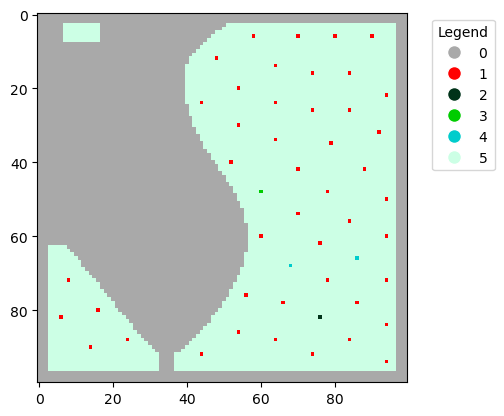

In [75]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = customDiscreteDistanceBoundarySpatialEnv(random.uniform(1,2))
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

In [62]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(octave):
    def _init():
        return customDiscreteDistanceBoundarySpatialEnv(octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs2 = DummyVecEnv([make_env(random.uniform(1,2)) for env in range(30)])

In [63]:
import gc
gc.collect()

14247

In [64]:
from stable_baselines3 import PPO

model = PPO("MultiInputPolicy", 
             envs2, 
             n_steps= 5,
             n_epochs= 10,
             batch_size= 5 * 30,
             verbose=0,
             tensorboard_log="./ppo_spatial_tensorboard/")

In [65]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 100000
total_timesteps = max_runs* 10

model.learn(total_timesteps=total_timesteps, progress_bar=True)
print(evaluate_policy(model, envs2, n_eval_episodes=20, warn=False))

Output()

(2.6, 2.4576411454889016)


999


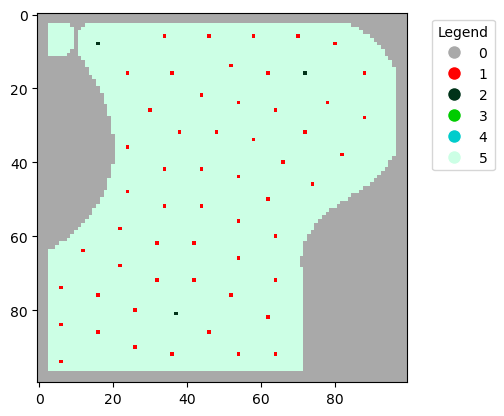

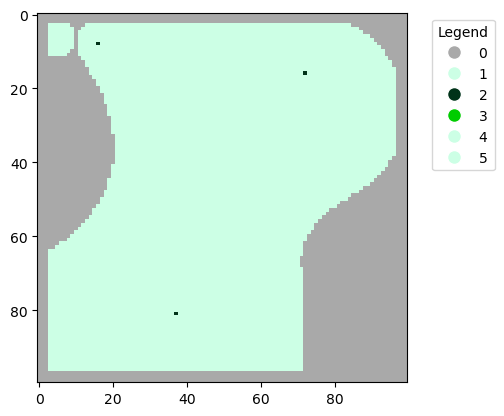

In [81]:
eval_env = customDiscreteDistanceBoundarySpatialEnv(random.uniform(1,2))
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()        
        eval_env.render(True)
        break

In [80]:
model.save('models/max_trees.zip')

### DIFFERENT ACTION SPACE

In [102]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

# Environment Class
class customDiscreteSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customDiscreteSpatialEnv, self).__init__()
        # Steps
        self.current_step = 0
        self.max_step = 1000

        # Base Variables
        self.minimum_distance = 10
        self.padded_boundary = 5
        self.contour_distance = 5

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        
        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}

        # Observation space
        self.observation_space = spaces.Dict(
            {
            "Coordinates": spaces.Box(low=-1, high=10, shape=(self.maximum_planting_spots, 2), dtype=np.int64),
            "Boundary": spaces.Box(low=-1, high=1, shape=(self.maximum_planting_spots, 1), dtype=np.int64),
            "Curve": spaces.Box(low=-1, high=1, shape=(self.maximum_planting_spots, 1), dtype=np.int64),
            "Tree": spaces.Box(low=-1, high=1, shape=(self.maximum_planting_spots, 1), dtype=np.int64),
            "Classified": spaces.Box(low=-1, high=1, shape=(self.maximum_planting_spots, 1), dtype=np.int64),
            "Density": spaces.Box(low=0, high=1, shape=(3,1), dtype=np.float32)
            }
        )
        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([10, 10, 3])
    
   
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])

            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break
        
        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_coordinate_boundary_ratio(self, xcoord:int, ycoord:int):
        """
        Function to generate the x and y ratio of the coordinate to the boundary from the left and top

        Args:
            xcoord (int): x coordinate of planting spot
            ycoord (int): y coordinate of planting spot

        Returns:
            (ratio_x, ratio_y) (tuple)
        """
        boundary = [] #[xleft, xright, ytop, ybottom]

        # Checking x coordinate ratio
        for x in range(xcoord, -1, -1): 
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x == 0:
                boundary.append(x)
        
        for x in range(xcoord, self.grid_size[0]):
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x  == (self.grid_size[0] - 1):
                boundary.append(x)

        # Checking y coordinate ratio
        for y in range(ycoord, -1, -1): 
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == 0:
                boundary.append(y)
        
        for y in range(ycoord, self.grid_size[1]):
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == (self.grid_size[1] - 1):
                boundary.append(y)

        try:
            # Retrieve ratio
            x_length = max(boundary[1] - boundary[0], 1)
            ratio_x = int(round((xcoord-boundary[0]) / x_length, 4)*10)
            
            y_length = max(boundary[3] - boundary[2], 1)
            ratio_y = int(round((ycoord-boundary[2]) / y_length, 4)*10)
            return (ratio_x, ratio_y)
        except:
            print(boundary, xcoord, ycoord)


    def _get_contours(self, xcoord:int, ycoord:int):
        grid_distance = distance_transform_edt(self.filled_boundary)
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0) 
        if chosen_contour <= 1:
            near_boundary = 1
        else:
            near_boundary = 0       
        return near_boundary, round(coordinate_distance, 4)


    def _get_near_curve(self, curve_distance:dict, ratio_list:list):
        # Assume all are curves
        boundary_list = [1] * len(ratio_list)

        for value_list in curve_distance.values():
            # No duplicates
            if len(value_list) <= 1:
                continue
            # Multiple coordinate with same distance
            else:
                seen_x = set()
                seen_y = set()
                for x, y in value_list:
                    # Check if vertically or horizontally aligned coordinates have the same distance, if yes likely in a straight line
                    if x in seen_x or y in seen_y:
                        ratio_index = ratio_list.index((x,y))
                        boundary_list[ratio_index] = 0
                    seen_x.add(x)
                    seen_y.add(y)
                
        return boundary_list


    def _embed_coordinates(self, planting_coordinates:np.ndarray, num_plants:int):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        curve_distance = {}
        ratio_list = []

        # Padded
        normalised_planting_list = np.full((num_plants, 6), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            ratio_coords = self._get_coordinate_boundary_ratio(planting_coords[1], planting_coords[0])
            contour_value, contour_dist = self._get_contours(planting_coords[1], planting_coords[0])
            # Update distance in the distance dictionary 
            distance_coord_list = curve_distance.get(contour_dist, [])
            distance_coord_list.append((ratio_coords[0], ratio_coords[1]))
            curve_distance[contour_dist] = distance_coord_list
            ratio_list.append((ratio_coords[0], ratio_coords[1]))
            # Update data
            normalised_planting_list[i] = ratio_coords + (contour_value, 0) + (1, 0)
            self.obv_planting_coordinates[i] = (planting_coords[1], planting_coords[0])
        
        boundary_list = self._get_near_curve(curve_distance, ratio_list)
        normalised_planting_list[:len(boundary_list), 3] = boundary_list
        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return {
            "Coordinates": self.normalised_planting_list[:, :2],
            "Boundary": self.normalised_planting_list[:, 2:3],
            "Curve": self.normalised_planting_list[:, 3:4],
            "Tree": self.normalised_planting_list[:, 4:5],
            "Classified": self.normalised_planting_list[:, 5:6],
            "Density": np.array(list(self.class_density.values())).reshape(3,1).astype(np.float32)
        }


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        return self._get_observation() , {}


    def step(self, action):
        self.current_step += 1
        reward = 0

        # Decode action
        x_ratio = action[0]
        y_ratio = action[1]
        class_value = action[2]

        chosen_index = self._retrieve_closest_coordinate(x_ratio, y_ratio)
        if chosen_index == -1:
            reward = 0

        else: 
            # Update grid, class count and planting list to now be planted
            chosen_value = self.normalised_planting_list[chosen_index]

            # Unplantable Tree, do not update grid
            if class_value == 0 and chosen_value[-2] == 0:
                reward += 1
            
            # Plantable, update grid
            else:
                chosen_coordinates = self.obv_planting_coordinates[chosen_index]
                self.grid[chosen_coordinates[1], chosen_coordinates[0]] = class_value + 2
                self.class_count[class_value] += 1
                self.normalised_planting_list[chosen_index][-1] = 1

                # Tree Logic
                if class_value == 0:
                    self.tree_coordinates.append((chosen_coordinates[1], chosen_coordinates[0]))
                    # Tree Plantable (from prev checking)
                    if chosen_value[-3] == 1 and chosen_value[-4] == 1:
                        reward += 3

                    elif chosen_value[-4] == 1: # Near Boundary
                        reward += 2

                    elif chosen_value[-3] == 1: # Near Curve but not near boundary
                        reward += 2
                    
                    else:
                        reward += 1
                    # Update plantable
                    self._update_tree_distance()

                # Shrub Logic
                elif class_value == 1:
                    if chosen_value[-4] == 0: # Nearer to boundary, penalise
                        reward += 2
                    else: # Nearer to center, reward
                        reward += 1
                
                # NA Logic
                else:
                    if chosen_value[-4] == 1: # Nearer to boundary, reward
                        reward += 2
                    else:
                        reward += 1

                # Check plant density
                density_reward = self._calculate_density_reward(class_value)
                reward += density_reward

            # if self.current_step > 200:
            #     reward -= 1/10* (self.current_step-200)
            
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -1], [1, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), reward, done ,False, {}


    def _retrieve_closest_coordinate(self, xratio:int, yratio:int):
        # Pick the closest plantable coordinate
        filtered_data = self.normalised_planting_list[
            ((self.normalised_planting_list[:, 0].astype(int) == xratio) &
            (self.normalised_planting_list[:, 1].astype(int) == yratio) &
            (self.normalised_planting_list[:, -1].astype(int) == 0))
        ]
        if filtered_data.size > 0:
            closest_index = np.where(np.all(self.normalised_planting_list == filtered_data[0], axis=1))[0][0]

        else:
            closest_index = -1

        return closest_index
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-2] = 0


    def _calculate_density_reward(self, class_value):
        total_count = len(self.planting_coordinates)
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density
        
        reward = 0
        if self.class_density[0] >= 0.2:
            reward += 1
        
        if self.class_density[1] >= 0.3 and self.class_density[1] <= 0.5:
            reward += 1

        if self.class_density[2] <= 0.2:
            reward += 1
        
        return reward

    def render(self, only_plant:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }

        img = np.zeros((100, 100, 3))
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        for value, color in value_to_colour.items():
            img[self.grid == value] = color

        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                
        plt.imshow(img)
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


    # def render(self):
    #     value_to_colour = {
    #         0: (169/255, 169/255, 169/255),  # Grey
    #         1: (1, 0, 0),                   # Red
    #         2: (0, 51/255, 25/255),          # Dark green
    #         3: (0, 204/255, 0),              # Bright green
    #         4: (0/255, 204/255, 204/255),    # Cyan
    #         5: (204/255, 255/255, 229/255)   # Light green
    #     }
        
    #     img = np.zeros((100, 100, 3))

    #     # Coloring the grid based on values
    #     for value, color in value_to_colour.items():
    #         img[self.grid == value] = color

    #     # Highlight filled boundary
    #     img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
    #     plt.figure(figsize=(12, 12))

    #     # Show the grid image
    #     plt.imshow(img, origin='lower')  # Set origin to lower to align with the grid's coordinate system

    #     # Set proper axis limits to ensure correct placement of labels
    #     plt.xlim(0, img.shape[1])
    #     plt.ylim(0, img.shape[0])


    #     # Plot each coordinate and label them with [a,b]
    #     for i, coord in enumerate(self.normalised_planting_list):
    #         a, b, c, d, _, _ = coord
    #         if a == -1:
    #             continue  # Skip unclassifiable points
    #         else:
    #             x,y = self.obv_planting_coordinates[i]
    #             # Add 0.5 to place text in the center of the cell
    #             plt.text(x, y, f"{a,b, c, d}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')

    #     # Add legend
    #     handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
    #     labels = list(value_to_colour.keys())
    #     plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

    #     plt.show()


[3 3 1]
[ 8 24]


c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation Boundary has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation Classified has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation Coordinates has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
c:

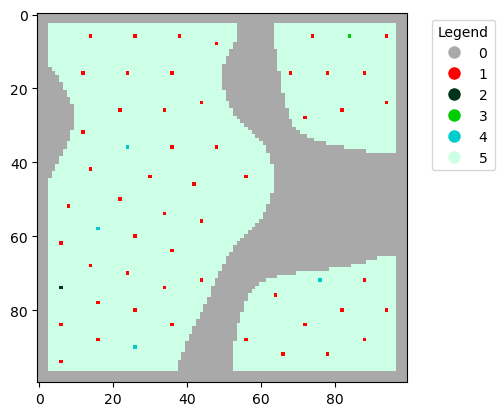

In [100]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = customDiscreteSpatialEnv(random.uniform(1,2))
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

In [41]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(octave):
    def _init():
        return customDiscreteSpatialEnv(octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs = DummyVecEnv([make_env(random.uniform(1,2)) for env in range(30)])

In [42]:
import gc
gc.collect()

45858

In [44]:
from stable_baselines3 import PPO

model = PPO("MultiInputPolicy", 
             envs, 
             n_steps= 3,
             n_epochs= 3,
             batch_size= 3 * 30,
             verbose=0,
             tensorboard_log="./ppo_spatial_tensorboard/")

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 100000
total_timesteps = max_runs* 10

model.learn(total_timesteps=total_timesteps, progress_bar=True)
print(evaluate_policy(model, envs, n_eval_episodes=20, warn=False))

In [103]:
eval_env = customDiscreteSpatialEnv(random.uniform(1,2))
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()        
        eval_env.render(True)
        break

IndexError: index 2 is out of bounds for axis 0 with size 2

### Different Action Space

In [119]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

# Environment Class
class customDiscreteIndexSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customDiscreteIndexSpatialEnv, self).__init__()
        # Steps
        self.current_step = 0
        self.max_step = 1000

        # Base Variables
        self.minimum_distance = 10
        self.padded_boundary = 5
        self.contour_distance = 5

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        
        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}

        # Observation space
        self.observation_space = spaces.Dict(
            {
            "Coordinates": spaces.Box(low=-1, high=10, shape=(self.maximum_planting_spots, 2), dtype=np.int64),
            "Boundary": spaces.Box(low=-1, high=1, shape=(self.maximum_planting_spots, 1), dtype=np.int64),
            "Curve": spaces.Box(low=-1, high=1, shape=(self.maximum_planting_spots, 1), dtype=np.int64),
            "Tree": spaces.Box(low=-1, high=1, shape=(self.maximum_planting_spots, 1), dtype=np.int64),
            "Classified": spaces.Box(low=-1, high=1, shape=(self.maximum_planting_spots, 1), dtype=np.int64),
            "Density": spaces.Box(low=0, high=1, shape=(3,1), dtype=np.float32)
            }
        )
        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([self.maximum_planting_spots, 3])
    
   
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])

            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break
        
        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_coordinate_boundary_ratio(self, xcoord:int, ycoord:int):
        """
        Function to generate the x and y ratio of the coordinate to the boundary from the left and top

        Args:
            xcoord (int): x coordinate of planting spot
            ycoord (int): y coordinate of planting spot

        Returns:
            (ratio_x, ratio_y) (tuple)
        """
        boundary = [] #[xleft, xright, ytop, ybottom]

        # Checking x coordinate ratio
        for x in range(xcoord, -1, -1): 
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x == 0:
                boundary.append(x)
        
        for x in range(xcoord, self.grid_size[0]):
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x  == (self.grid_size[0] - 1):
                boundary.append(x)

        # Checking y coordinate ratio
        for y in range(ycoord, -1, -1): 
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == 0:
                boundary.append(y)
        
        for y in range(ycoord, self.grid_size[1]):
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == (self.grid_size[1] - 1):
                boundary.append(y)

        try:
            # Retrieve ratio
            x_length = max(boundary[1] - boundary[0], 1)
            ratio_x = int(round((xcoord-boundary[0]) / x_length, 4)*10)
            
            y_length = max(boundary[3] - boundary[2], 1)
            ratio_y = int(round((ycoord-boundary[2]) / y_length, 4)*10)
            return (ratio_x, ratio_y)
        except:
            print(boundary, xcoord, ycoord)


    def _get_contours(self, xcoord:int, ycoord:int):
        grid_distance = distance_transform_edt(self.filled_boundary)
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0) 
        if chosen_contour <= 1:
            near_boundary = 1
        else:
            near_boundary = 0       
        return near_boundary, round(coordinate_distance, 4)


    def _get_near_curve(self, curve_distance:dict, ratio_list:list):
        # Assume all are curves
        boundary_list = [1] * len(ratio_list)

        for value_list in curve_distance.values():
            # No duplicates
            if len(value_list) <= 1:
                continue
            # Multiple coordinate with same distance
            else:
                seen_x = set()
                seen_y = set()
                for x, y in value_list:
                    # Check if vertically or horizontally aligned coordinates have the same distance, if yes likely in a straight line
                    if x in seen_x or y in seen_y:
                        ratio_index = ratio_list.index((x,y))
                        boundary_list[ratio_index] = 0
                    seen_x.add(x)
                    seen_y.add(y)
                
        return boundary_list


    def _embed_coordinates(self, planting_coordinates:np.ndarray, num_plants:int):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        curve_distance = {}
        ratio_list = []

        # Padded
        normalised_planting_list = np.full((num_plants, 6), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            ratio_coords = self._get_coordinate_boundary_ratio(planting_coords[1], planting_coords[0])
            contour_value, contour_dist = self._get_contours(planting_coords[1], planting_coords[0])
            # Update distance in the distance dictionary 
            distance_coord_list = curve_distance.get(contour_dist, [])
            distance_coord_list.append((ratio_coords[0], ratio_coords[1]))
            curve_distance[contour_dist] = distance_coord_list
            ratio_list.append((ratio_coords[0], ratio_coords[1]))
            # Update data
            normalised_planting_list[i] = ratio_coords + (contour_value, 0) + (1, 0)
            self.obv_planting_coordinates[i] = (planting_coords[1], planting_coords[0])
        
        boundary_list = self._get_near_curve(curve_distance, ratio_list)
        normalised_planting_list[:len(boundary_list), 3] = boundary_list
        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return {
            "Coordinates": self.normalised_planting_list[:, :2],
            "Boundary": self.normalised_planting_list[:, 2:3],
            "Curve": self.normalised_planting_list[:, 3:4],
            "Tree": self.normalised_planting_list[:, 4:5],
            "Classified": self.normalised_planting_list[:, 5:6],
            "Density": np.array(list(self.class_density.values())).reshape(3,1).astype(np.float32)
        }


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        return self._get_observation() , {}


    def step(self, action):
        self.current_step += 1
        reward = 0

        # Decode action
        chosen_index = action[0]
        class_value = action[1]

        chosen_value = self.normalised_planting_list[chosen_index]

        if chosen_value[-1] == -1 or chosen_value[-1] == 1:
            reward -= 0

        else:
            # Unplantable Tree, do not update grid
            if class_value == 0 and chosen_value[-2] == 0:
                reward += 1
            
            # Plantable, update grid
            else:
                chosen_coordinates = self.obv_planting_coordinates[chosen_index]
                self.grid[chosen_coordinates[1], chosen_coordinates[0]] = class_value + 2
                self.class_count[class_value] += 1
                self.normalised_planting_list[chosen_index][-1] = 1

                # Tree Logic
                if class_value == 0:
                    self.tree_coordinates.append((chosen_coordinates[1], chosen_coordinates[0]))
                    # Tree Plantable (from prev checking)
                    if chosen_value[-3] == 1 and chosen_value[-4] == 1:
                        reward += 4

                    elif chosen_value[-4] == 1: # Near Boundary
                        reward += 3

                    elif chosen_value[-3] == 1: # Near Curve but not near boundary
                        reward += 3
                    
                    else:
                        reward += 2
                    # Update plantable
                    self._update_tree_distance()

                # Shrub Logic
                elif class_value == 1:
                    if chosen_value[-4] == 0: # Nearer to boundary, penalise
                        reward += 2
                    else: # Nearer to center, reward
                        reward += 1
                
                # NA Logic
                else:
                    if chosen_value[-4] == 1: # Nearer to boundary, reward
                        reward += 2
                    else:
                        reward -= 1

                # Check plant density
                density_reward = self._calculate_density_reward(class_value)
                reward += density_reward

            # if self.current_step > 200:
            #     reward -= 1/10* (self.current_step-200)
            
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -1], [1, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), reward, done ,False, {}
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-2] = 0


    def _calculate_density_reward(self, class_value):
        total_count = len(self.planting_coordinates)
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density
        
        reward = 0
        if self.class_density[0] >= 0.05:
            reward += 1
        
        if self.class_density[1] >= 0.3 and self.class_density[1] <= 0.6:
            reward += 1

        if self.class_density[2] <= 0.3:
            reward += 1

        
        return reward


    def render(self, only_plant:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }

        img = np.zeros((100, 100, 3))
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        for value, color in value_to_colour.items():
            img[self.grid == value] = color

        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                
        plt.imshow(img)
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


    # def render(self):
    #     value_to_colour = {
    #         0: (169/255, 169/255, 169/255),  # Grey
    #         1: (1, 0, 0),                   # Red
    #         2: (0, 51/255, 25/255),          # Dark green
    #         3: (0, 204/255, 0),              # Bright green
    #         4: (0/255, 204/255, 204/255),    # Cyan
    #         5: (204/255, 255/255, 229/255)   # Light green
    #     }
        
    #     img = np.zeros((100, 100, 3))

    #     # Coloring the grid based on values
    #     for value, color in value_to_colour.items():
    #         img[self.grid == value] = color

    #     # Highlight filled boundary
    #     img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
    #     plt.figure(figsize=(12, 12))

    #     # Show the grid image
    #     plt.imshow(img, origin='lower')  # Set origin to lower to align with the grid's coordinate system

    #     # Set proper axis limits to ensure correct placement of labels
    #     plt.xlim(0, img.shape[1])
    #     plt.ylim(0, img.shape[0])


    #     # Plot each coordinate and label them with [a,b]
    #     for i, coord in enumerate(self.normalised_planting_list):
    #         a, b, c, d, _, _ = coord
    #         if a == -1:
    #             continue  # Skip unclassifiable points
    #         else:
    #             x,y = self.obv_planting_coordinates[i]
    #             # Add 0.5 to place text in the center of the cell
    #             plt.text(x, y, f"{a,b, c, d}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')

    #     # Add legend
    #     handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
    #     labels = list(value_to_colour.keys())
    #     plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

    #     plt.show()


[82  0]
[ 6 46]


c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation Boundary has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation Classified has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation Coordinates has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
c:

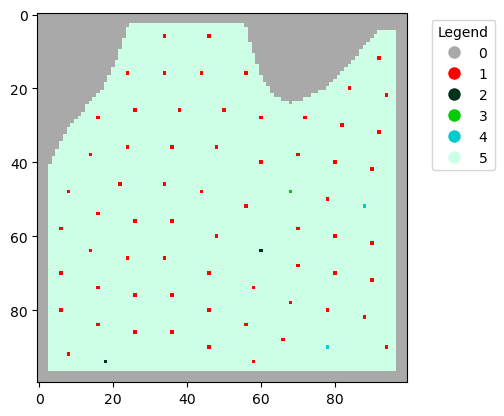

In [120]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = customDiscreteIndexSpatialEnv(random.uniform(1,2))
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

In [89]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(octave):
    def _init():
        return customDiscreteIndexSpatialEnv(octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs2 = DummyVecEnv([make_env(random.uniform(1,2)) for env in range(30)])

In [90]:
import gc
gc.collect()

3504

In [91]:
from stable_baselines3 import PPO

model = PPO("MultiInputPolicy", 
             envs2, 
             n_steps= 8,
             n_epochs= 10,
             batch_size= 8 * 30,
             verbose=0,
             tensorboard_log="./ppo_spatial_tensorboard/")

In [92]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 100000
total_timesteps = max_runs* 10

model.learn(total_timesteps=total_timesteps, progress_bar=True)
print(evaluate_policy(model, envs2, n_eval_episodes=20, warn=False))

Output()

(2816.35, 399.31244345750105)


999


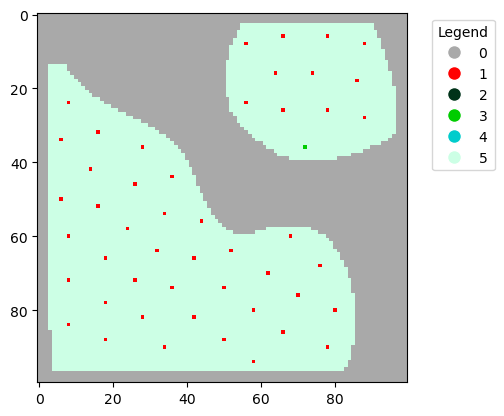

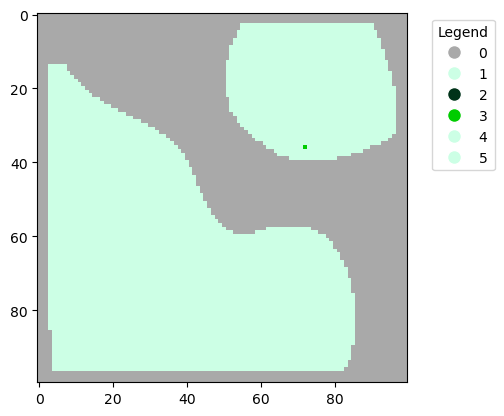

In [105]:
eval_env = customDiscreteIndexSpatialEnv(random.uniform(1,2))
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()        
        eval_env.render(True)
        break

### MAXIMISE TREES

In [26]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass
import math

# Environmennt Class
class MaximiseTrees1(gym.Env):
    def __init__(self, octave:float, theme:int, grid_size:tuple=(100,100)):
        super(MaximiseTrees1, self).__init__()

        # Steps
        self.current_step = 0
        self.max_step = 100

        # Base Variables
        self.minimum_distance = 10
        self.tree_distance = 50
        self.padded_boundary = 5
        self.contour_distance = 5
        self.theme = theme

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()

        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x

        # Observation space
        self.observation_space = spaces.Box(low=-1, high=100, shape=((self.maximum_planting_spots), 3), dtype=np.int64)

        # Determine if wna include contour as a action sapce
        self.action_space = spaces.Discrete((self.maximum_planting_spots))


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed= random.randint(0,50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())
            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_contours(self):
        labeled_array, num_features = label(self.filled_boundary)
        # Prepare an array to store distances from the center of each area
        distance_from_center = np.zeros_like(self.filled_boundary, dtype=float)

        # For each labeled component, calculate distances from the centroid
        for label_num in range(1, num_features + 1):
            # Find the centroid of the current component
            centroid = center_of_mass(self.filled_boundary, labeled_array, label_num)
            # Create a mask for the current component
            mask = labeled_array == label_num
            # Get the coordinates of points in the current component
            coords = np.argwhere(mask)
            # Calculate distances from the centroid for each point in the component
            for coord in coords:
                distance = np.sqrt((coord[0] - centroid[0])**2 + (coord[1] - centroid[1])**2)
                distance_from_center[tuple(coord)] = distance

        # Round distances to the nearest integer
        return np.round(distance_from_center).astype(int)


    def _embed_coordinates(self, planting_coordinates:np.ndarray):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        # Padded
        normalised_planting_list = np.full(((self.maximum_planting_spots), 5), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        if self.theme == 0:
            # Boundary
            grid_distance  = self._get_contours()
        else:
            grid_distance =  np.round(distance_transform_edt(self.filled_boundary)).astype(int)

        max_value = grid_distance.max()
        min_value = grid_distance.min()
        min_distance = (max_value-min_value) * (0.4) +  min_value
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            # Update data
            distance = grid_distance[planting_coords[0], planting_coords[1]]
            plantable = 1 if distance >= min_distance else 0
            normalised_planting_list[i] = (planting_coords[1], planting_coords[0], distance, plantable, 0)
        
        return normalised_planting_list.astype(np.int64)
    

    def _get_observation(self):
        return self.normalised_planting_list[:, 2:]

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.tree_coordinates = []
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)
        return self._get_observation() , {}

    
    def step(self, action):
        self.current_step += 1
        reward = 0
        chosen_value = self.normalised_planting_list[action]

        # Unplantable Tree, do not update grid
        if chosen_value[-2] == 0:
            reward += 0

        elif chosen_value[-1] == 1 or chosen_value[-1] == -1:
            reward -= 1 
        
        # Plantable, update grid
        else:
            self.grid[chosen_value[1], chosen_value[0]] = 2
            self.normalised_planting_list[action][-1] = 1
            self.tree_coordinates.append((chosen_value[1], chosen_value[0]))
            reward += math.exp(chosen_value[2]/10)
            self._update_tree_distance()

        done = bool(np.all(np.isin(self.normalised_planting_list[:, -2], [0, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), float(reward), done ,False, {}
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-2] = 0


    def render(self, only_plant:bool=False, show_coord:bool=False):

        if not show_coord:
            value_to_colour_all = {
                0: (169/255, 169/255, 169/255),
                1: (1, 0, 0),
                2: (0, 51/255, 25/255),
                3: (0, 204/255, 0),
                4: (0/255, 204/255, 204/255),
                5: (204/255, 255/255, 229/255)
            }

            value_to_colour_plant={
                0: (169/255, 169/255, 169/255),
                1: (204/255, 255/255, 229/255),
                2: (0, 51/255, 25/255),
                3: (0, 204/255, 0),
                4: (204/255, 255/255, 229/255),
                5: (204/255, 255/255, 229/255)
            }

            img = np.zeros((100, 100, 3))
            
            value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

            for value, color in value_to_colour.items():
                img[self.grid == value] = color

            img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                    
            plt.imshow(img)
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
            labels = list(value_to_colour.keys())
            plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()

        else:
            value_to_colour = {
                0: (169/255, 169/255, 169/255),  # Grey
                1: (1, 0, 0),                   # Red
                2: (0, 51/255, 25/255),          # Dark green
                3: (0, 204/255, 0),              # Bright green
                4: (0/255, 204/255, 204/255),    # Cyan
                5: (204/255, 255/255, 229/255)   # Light green
            }
            
            img = np.zeros((100, 100, 3))

            # Coloring the grid based on values
            for value, color in value_to_colour.items():
                img[self.grid == value] = color

            # Highlight filled boundary
            img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
            plt.figure(figsize=(12, 12))

            # Show the grid image
            plt.imshow(img)  # Set origin to lower to align with the grid's coordinate system

            # Set proper axis limits to ensure correct placement of labels
            plt.xlim(0, img.shape[1])
            plt.ylim(0, img.shape[0])


            # Plot each coordinate and label them with [a,b]
            for i, coord in enumerate(self.normalised_planting_list):
                a, b, c, d, _ = coord
                # Add 0.5 to place text in the center of the cell
                plt.text(a, b, f"{c, d}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')

            # Add legend
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
            labels = list(value_to_colour.keys())
            plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.show()


### EXPLORATION

In [3]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass
import math

# Environmennt Class
class MaximiseTrees(gym.Env):
    def __init__(self, octave:float, theme:int, grid_size:tuple=(100,100)):
        super(MaximiseTrees, self).__init__()

        # Steps
        self.current_step = 0
        self.max_step = 25

        # Base Variables
        self.minimum_distance = 10
        self.tree_distance = 50
        self.padded_boundary = 5
        self.contour_distance = 5
        self.theme = theme

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()

        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x

        # Observation space
        self.observation_space = spaces.Box(low=-1, high=100, shape=((self.maximum_planting_spots), 2), dtype=np.int64)

        # Determine if wna include contour as a action sapce
        self.action_space = spaces.Discrete((self.maximum_planting_spots))


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed= random.randint(0,50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())
            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_contours(self):
        labeled_array, num_features = label(self.filled_boundary)
        # Prepare an array to store distances from the center of each area
        distance_from_center = np.zeros_like(self.filled_boundary, dtype=float)

        # For each labeled component, calculate distances from the centroid
        for label_num in range(1, num_features + 1):
            # Find the centroid of the current component
            centroid = center_of_mass(self.filled_boundary, labeled_array, label_num)
            # Create a mask for the current component
            mask = labeled_array == label_num
            # Get the coordinates of points in the current component
            coords = np.argwhere(mask)
            # Calculate distances from the centroid for each point in the component
            for coord in coords:
                distance = np.sqrt((coord[0] - centroid[0])**2 + (coord[1] - centroid[1])**2)
                distance_from_center[tuple(coord)] = distance

        # Round distances to the nearest integer
        return np.round(distance_from_center).astype(int)


    def _embed_coordinates(self, planting_coordinates:np.ndarray):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        # Padded
        normalised_planting_list = np.full(((self.maximum_planting_spots), 5), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        if self.theme == 0:
            # Boundary
            grid_distance  = self._get_contours()
        else:
            grid_distance =  np.round(distance_transform_edt(self.filled_boundary)).astype(int)

        max_value = grid_distance.max()
        min_value = grid_distance.min()
        min_distance = (max_value-min_value) * (0.25) +  min_value
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            # Update data
            distance = grid_distance[planting_coords[0], planting_coords[1]]
            plantable = 1 if distance >= min_distance else 0
            normalised_planting_list[i] = (planting_coords[1], planting_coords[0], distance, plantable, 0)
        
        return normalised_planting_list.astype(np.int64)
    

    def _get_observation(self):
        return self.normalised_planting_list[:, 3:]

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.tree_coordinates = []
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)
        return self._get_observation() , {}

    
    def step(self, action):
        self.current_step += 1
        reward = 0
        chosen_value = self.normalised_planting_list[action]

        # Unplantable Tree, do not update grid
        if chosen_value[-2] == 0:
            reward += 0

        elif chosen_value[-1] == 1 or chosen_value[-1] == -1:
            reward -= 1 
        
        # Plantable, update grid
        else:
            self.grid[chosen_value[1], chosen_value[0]] = 2
            self.normalised_planting_list[action][-1] = 1
            self.tree_coordinates.append((chosen_value[1], chosen_value[0]))
            reward += 1
            self._update_tree_distance()

        done = bool(np.all(np.isin(self.normalised_planting_list[:, -2], [0, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), float(reward), done ,False, {}
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-2] = 0


    def render(self, only_plant:bool=False, show_coord:bool=False):

        if not show_coord:
            value_to_colour_all = {
                0: (169/255, 169/255, 169/255),
                1: (1, 0, 0),
                2: (0, 51/255, 25/255),
                3: (0, 204/255, 0),
                4: (0/255, 204/255, 204/255),
                5: (204/255, 255/255, 229/255)
            }

            value_to_colour_plant={
                0: (169/255, 169/255, 169/255),
                1: (204/255, 255/255, 229/255),
                2: (0, 51/255, 25/255),
                3: (0, 204/255, 0),
                4: (204/255, 255/255, 229/255),
                5: (204/255, 255/255, 229/255)
            }

            img = np.zeros((100, 100, 3))
            
            value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

            for value, color in value_to_colour.items():
                img[self.grid == value] = color

            img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                    
            plt.imshow(img)
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
            labels = list(value_to_colour.keys())
            plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()

        else:
            value_to_colour = {
                0: (169/255, 169/255, 169/255),  # Grey
                1: (1, 0, 0),                   # Red
                2: (0, 51/255, 25/255),          # Dark green
                3: (0, 204/255, 0),              # Bright green
                4: (0/255, 204/255, 204/255),    # Cyan
                5: (204/255, 255/255, 229/255)   # Light green
            }
            
            img = np.zeros((100, 100, 3))

            # Coloring the grid based on values
            for value, color in value_to_colour.items():
                img[self.grid == value] = color

            # Highlight filled boundary
            img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
            plt.figure(figsize=(12, 12))

            # Show the grid image
            plt.imshow(img)  # Set origin to lower to align with the grid's coordinate system

            # Set proper axis limits to ensure correct placement of labels
            plt.xlim(0, img.shape[1])
            plt.ylim(0, img.shape[0])


            # Plot each coordinate and label them with [a,b]
            for i, coord in enumerate(self.normalised_planting_list):
                a, b, c, d, _ = coord
                # Add 0.5 to place text in the center of the cell
                plt.text(a, b, f"{c, d}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')

            # Add legend
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
            labels = list(value_to_colour.keys())
            plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.show()


In [261]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass


# Environmennt Class
class MaximiseBoundaryTrees(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        super(MaximiseBoundaryTrees, self).__init__()

        # Steps
        self.current_step = 0
        self.max_step = 100

        # Base Variables
        self.minimum_distance = 10
        self.tree_distance = 50
        self.padded_boundary = 5
        self.contour_distance = 5

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()

        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x

        # Observation space
        self.observation_space = spaces.Box(low=-1, high=100, shape=((self.maximum_planting_spots), 3), dtype=np.int64)

        # Determine if wna include contour as a action sapce
        self.action_space = spaces.Discrete((self.maximum_planting_spots))


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed= random.randint(0,50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())
            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_contours(self):
        labeled_array, num_features = label(self.filled_boundary)
        # Prepare an array to store distances from the center of each area
        distance_from_center = np.zeros_like(self.filled_boundary, dtype=float)

        # For each labeled component, calculate distances from the centroid
        for label_num in range(1, num_features + 1):
            # Find the centroid of the current component
            centroid = center_of_mass(self.filled_boundary, labeled_array, label_num)
            # Create a mask for the current component
            mask = labeled_array == label_num
            # Get the coordinates of points in the current component
            coords = np.argwhere(mask)
            # Calculate distances from the centroid for each point in the component
            for coord in coords:
                distance = np.sqrt((coord[0] - centroid[0])**2 + (coord[1] - centroid[1])**2)
                distance_from_center[tuple(coord)] = distance

        # Round distances to the nearest integer
        return np.round(distance_from_center).astype(int)


    def _embed_coordinates(self, planting_coordinates:np.ndarray):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        # Padded
        normalised_planting_list = np.full(((self.maximum_planting_spots), 5), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        grid_distance  = self._get_contours()

        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            # Update data
            normalised_planting_list[i] = (planting_coords[1], planting_coords[0], grid_distance[planting_coords[0], planting_coords[1]], 1, 0)
        
        return normalised_planting_list.astype(np.int64)
    

    def _get_observation(self):
        return self.normalised_planting_list[:, 2:]

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.tree_coordinates = []
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)
        return self._get_observation() , {}

    
    def step(self, action):
        self.current_step += 1
        reward = 0
        chosen_value = self.normalised_planting_list[action]

        # Unplantable Tree, do not update grid
        if chosen_value[-2] == 0:
            reward += 0

        elif chosen_value[-1] == 1 or chosen_value[-1] == -1:
            reward -= 1 
        
        # Plantable, update grid
        else:
            self.grid[chosen_value[1], chosen_value[0]] = 2
            self.normalised_planting_list[action][-1] = 1
            self.tree_coordinates.append((chosen_value[1], chosen_value[0]))
            reward += chosen_value[2]
            self._update_tree_distance()

        done = bool(np.all(np.isin(self.normalised_planting_list[:, -2], [0, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), float(reward), done ,False, {}
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-2] = 0


    def render(self, only_plant:bool=False, show_coord:bool=False):

        if not show_coord:
            value_to_colour_all = {
                0: (169/255, 169/255, 169/255),
                1: (1, 0, 0),
                2: (0, 51/255, 25/255),
                3: (0, 204/255, 0),
                4: (0/255, 204/255, 204/255),
                5: (204/255, 255/255, 229/255)
            }

            value_to_colour_plant={
                0: (169/255, 169/255, 169/255),
                1: (204/255, 255/255, 229/255),
                2: (0, 51/255, 25/255),
                3: (0, 204/255, 0),
                4: (204/255, 255/255, 229/255),
                5: (204/255, 255/255, 229/255)
            }

            img = np.zeros((100, 100, 3))
            
            value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

            for value, color in value_to_colour.items():
                img[self.grid == value] = color

            img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                    
            plt.imshow(img)
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
            labels = list(value_to_colour.keys())
            plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()

        else:
            value_to_colour = {
                0: (169/255, 169/255, 169/255),  # Grey
                1: (1, 0, 0),                   # Red
                2: (0, 51/255, 25/255),          # Dark green
                3: (0, 204/255, 0),              # Bright green
                4: (0/255, 204/255, 204/255),    # Cyan
                5: (204/255, 255/255, 229/255)   # Light green
            }
            
            img = np.zeros((100, 100, 3))

            # Coloring the grid based on values
            for value, color in value_to_colour.items():
                img[self.grid == value] = color

            # Highlight filled boundary
            img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
            plt.figure(figsize=(12, 12))

            # Show the grid image
            plt.imshow(img)  # Set origin to lower to align with the grid's coordinate system

            # Set proper axis limits to ensure correct placement of labels
            plt.xlim(0, img.shape[1])
            plt.ylim(0, img.shape[0])


            # Plot each coordinate and label them with [a,b]
            for i, coord in enumerate(self.normalised_planting_list):
                a, b, c, d, _ = coord
                # Add 0.5 to place text in the center of the cell
                plt.text(a, b, f"{c, d}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')

            # Add legend
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
            labels = list(value_to_colour.keys())
            plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.show()


In [251]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass


# Environmennt Class
class MaximiseWalkwayTrees(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        super(MaximiseWalkwayTrees, self).__init__()

        # Steps
        self.current_step = 0
        self.max_step = 100

        # Base Variables
        self.minimum_distance = 10
        self.tree_distance = 50
        self.padded_boundary = 5
        self.contour_distance = 5

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()

        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x

        # Observation space
        self.observation_space = spaces.Box(low=-1, high=100, shape=((self.maximum_planting_spots), 3), dtype=np.int64)

        # Determine if wna include contour as a action sapce
        self.action_space = spaces.Discrete((self.maximum_planting_spots))


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed= random.randint(0,50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())
            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _embed_coordinates(self, planting_coordinates:np.ndarray):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        # Padded
        normalised_planting_list = np.full(((self.maximum_planting_spots), 5), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        #walkway
        grid_distance =  np.round(distance_transform_edt(self.filled_boundary)).astype(int)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            # Update data
            normalised_planting_list[i] = (planting_coords[1], planting_coords[0], grid_distance[planting_coords[0], planting_coords[1]], 1, 0)
        
        return normalised_planting_list.astype(np.int64)
    

    def _get_observation(self):
        return self.normalised_planting_list[:, 2:]

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.tree_coordinates = []
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)
        return self._get_observation() , {}

    
    def step(self, action):
        self.current_step += 1
        reward = 0
        chosen_value = self.normalised_planting_list[action]

        # Unplantable Tree, do not update grid
        if chosen_value[-2] == 0:
            reward += 0

        elif chosen_value[-1] == 1 or chosen_value[-1] == -1:
            reward -= 1 
        
        # Plantable, update grid
        else:
            self.grid[chosen_value[1], chosen_value[0]] = 2
            self.normalised_planting_list[action][-1] = 1
            self.tree_coordinates.append((chosen_value[1], chosen_value[0]))
            reward += chosen_value[2]
            self._update_tree_distance()

        done = bool(np.all(np.isin(self.normalised_planting_list[:, -2], [0, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), float(reward), done ,False, {}
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-2] = 0


    def render(self, only_plant:bool=False, show_coord:bool=False):

        if not show_coord:
            value_to_colour_all = {
                0: (169/255, 169/255, 169/255),
                1: (1, 0, 0),
                2: (0, 51/255, 25/255),
                3: (0, 204/255, 0),
                4: (0/255, 204/255, 204/255),
                5: (204/255, 255/255, 229/255)
            }

            value_to_colour_plant={
                0: (169/255, 169/255, 169/255),
                1: (204/255, 255/255, 229/255),
                2: (0, 51/255, 25/255),
                3: (0, 204/255, 0),
                4: (204/255, 255/255, 229/255),
                5: (204/255, 255/255, 229/255)
            }

            img = np.zeros((100, 100, 3))
            
            value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

            for value, color in value_to_colour.items():
                img[self.grid == value] = color

            img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                    
            plt.imshow(img)
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
            labels = list(value_to_colour.keys())
            plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()

        else:
            value_to_colour = {
                0: (169/255, 169/255, 169/255),  # Grey
                1: (1, 0, 0),                   # Red
                2: (0, 51/255, 25/255),          # Dark green
                3: (0, 204/255, 0),              # Bright green
                4: (0/255, 204/255, 204/255),    # Cyan
                5: (204/255, 255/255, 229/255)   # Light green
            }
            
            img = np.zeros((100, 100, 3))

            # Coloring the grid based on values
            for value, color in value_to_colour.items():
                img[self.grid == value] = color

            # Highlight filled boundary
            img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
            plt.figure(figsize=(12, 12))

            # Show the grid image
            plt.imshow(img)  # Set origin to lower to align with the grid's coordinate system

            # Set proper axis limits to ensure correct placement of labels
            plt.xlim(0, img.shape[1])
            plt.ylim(0, img.shape[0])


            # Plot each coordinate and label them with [a,b]
            for i, coord in enumerate(self.normalised_planting_list):
                a, b, c, d, _ = coord
                # Add 0.5 to place text in the center of the cell
                plt.text(a, b, f"{c, d}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')

            # Add legend
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
            labels = list(value_to_colour.keys())
            plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.show()


27
[ 6 46]


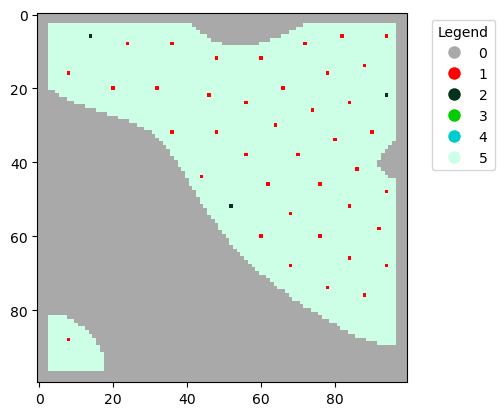

In [254]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = MaximiseBoundaryTrees(random.uniform(1,2))
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

85
[ 6 70]


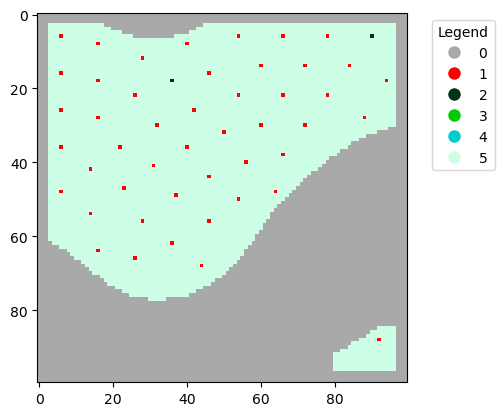

In [298]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = MaximiseWalkwayTrees(random.uniform(1,2))
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()
# test.render(show_coord=True)

36
[ 6 42]


c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


1


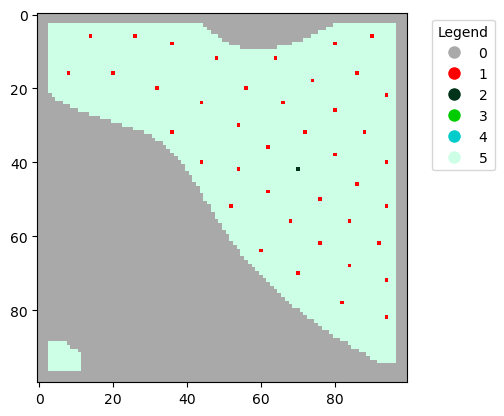

In [2]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = MaximiseTrees(random.uniform(1,2), random.randint(0,1))
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
print(test.theme)
test.render()
# test.render(show_coord=True)


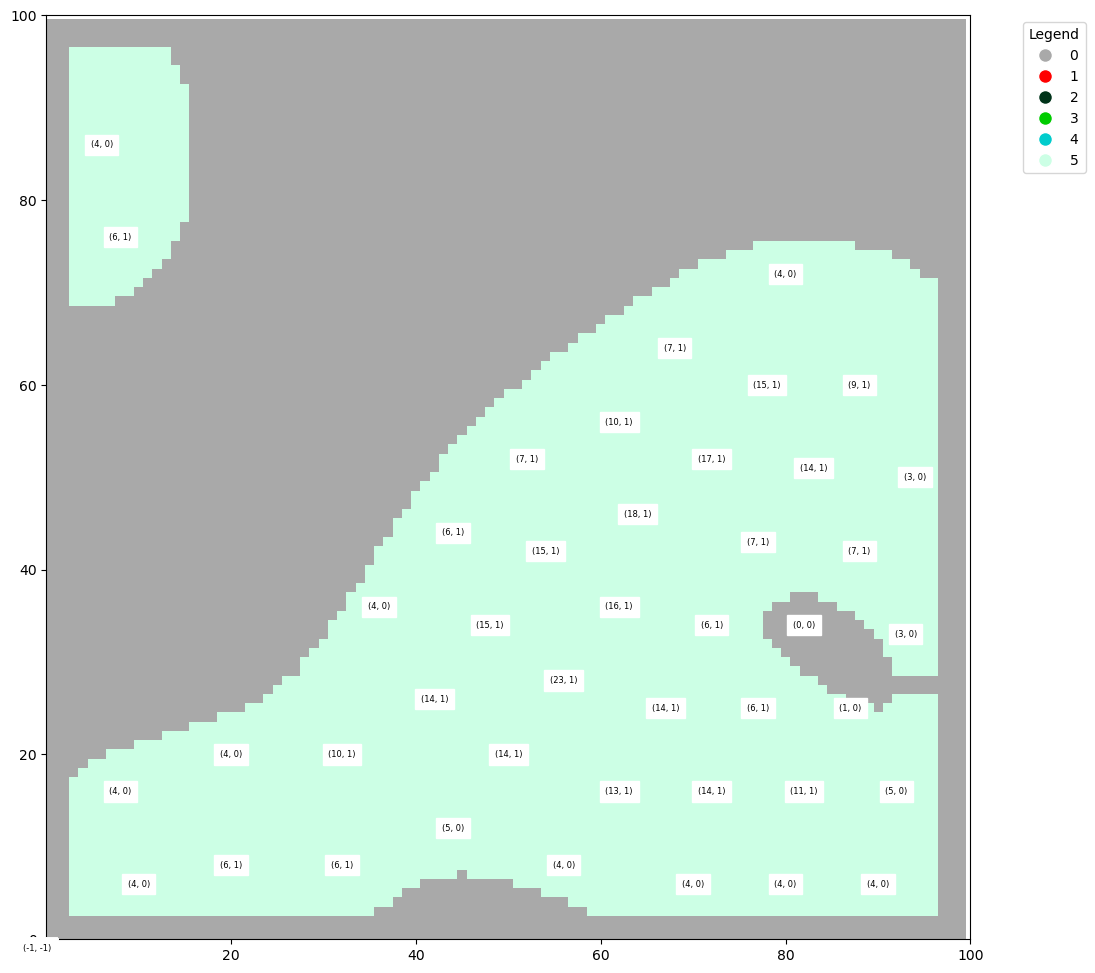

In [14]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = MaximiseTrees(random.uniform(1,2), 1)
# print(test.action_space.sample()) #random action
# print(test.planting_coordinates[0]) #coordinates
# check_env(test)
# print(test.theme)
# test.render()
test.render(show_coord=True)

In [4]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(octave, theme):
    def _init():
        return MaximiseTrees(octave, theme)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs2 = DummyVecEnv([make_env(random.uniform(1,2),  random.randint(0,1)) for env in range(50)])

In [5]:
import gc
gc.collect()

3502

In [6]:
from stable_baselines3 import PPO

model = PPO("MlpPolicy", 
             envs2, 
             n_steps= 8,
             n_epochs=8,
             batch_size= 8 *50,
             verbose=0,
             tensorboard_log="./ppo_spatial_tensorboard/")

In [7]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 1000
total_timesteps = max_runs* 8

model.learn(total_timesteps=total_timesteps, progress_bar=True)
print(evaluate_policy(model, envs2, n_eval_episodes=5, warn=False))

Output()

(1.0, 0.0)


24


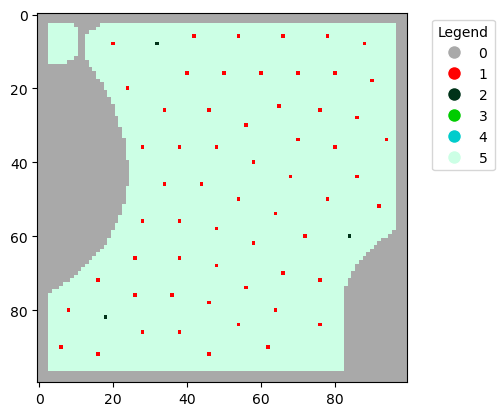

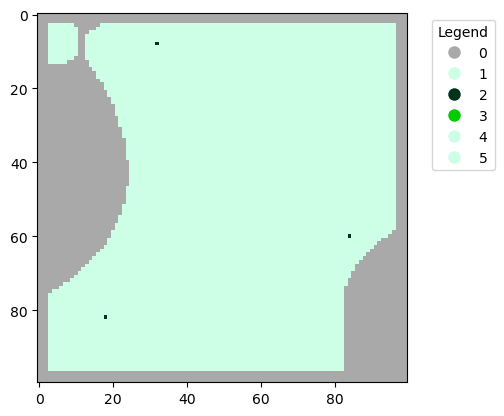

In [20]:
eval_env = MaximiseTrees(1.25, 0)
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()        
        eval_env.render(True)
        break

0


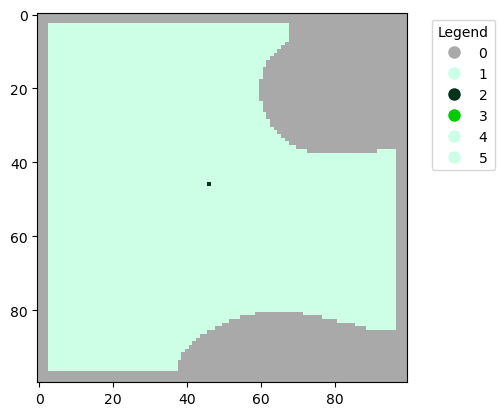

In [30]:
eval_env = MaximiseTrees(1.25, 1)
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render(True, False)
        break



In [380]:
model.save('models/Tre_Model.zip')

In [24]:
model2 = model.load('models/Tree_Model.zip')

1


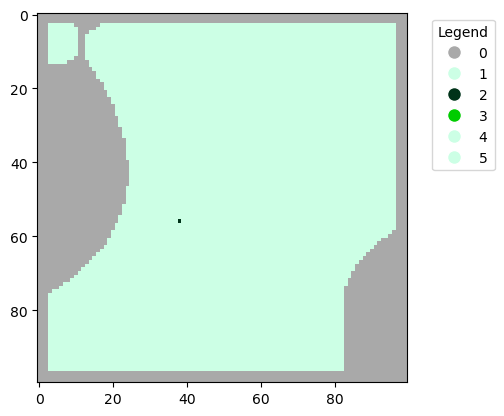

In [32]:
eval_env = MaximiseTrees1(1.25, 1)
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model2.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render(True, False)
        break



### MERGING OF ALL? TEST1

In [254]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass

class spatialEnv(gym.Env):
    def __init__(self, octave:float, theme:int, grid_size:tuple=(100,100)):
        """
            Args:
                context (int): either 0 or 1, 0 for roads while 1 for walkways
                octave (float): octave value from range [1-2] for perlin noise
                grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(spatialEnv, self).__init__()

        # Steps
        self.current_step = 0
        self.max_step = 250

        # Base Variables
        self.minimum_distance = 10
        self.tree_distance = 50
        self.padded_boundary = 5
        self.contour_distance = 5
        self.theme = theme
        
        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()

        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}

        # Observation space
        self.observation_space = spaces.Dict(
            {
                "Points": spaces.Box(low=-1, high=20, shape=(self.maximum_planting_spots, 6), dtype=np.int64),
                "Density": spaces.Box(low=0, high=1, shape=(3,1), dtype=np.float32)
            }
        )

        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([self.maximum_planting_spots, 3])


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed= random.randint(0,50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())
            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid
    

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates    
    
    
    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid
    

    def _distance_from_centre(self):
        labeled_array, num_features = label(self.filled_boundary)
        # Prepare an array to store distances from the center of each area
        distance_from_center = np.zeros_like(self.filled_boundary, dtype=float)

        # For each labeled component, calculate distances from the centroid
        for label_num in range(1, num_features + 1):
            # Find the centroid of the current component
            centroid = center_of_mass(self.filled_boundary, labeled_array, label_num)
            # Create a mask for the current component
            mask = labeled_array == label_num
            # Get the coordinates of points in the current component
            coords = np.argwhere(mask)
            # Calculate distances from the centroid for each point in the component
            for coord in coords:
                distance = np.sqrt((coord[0] - centroid[0])**2 + (coord[1] - centroid[1])**2)
                distance_from_center[tuple(coord)] = distance

        # Round distances to the nearest integer
        return distance_from_center
    

    def _get_contour(self, grid_distance, xcoord, ycoord):
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0) 
        # if chosen_contour <= 1:
        #     near_boundary = 1
        # else:
        #     near_boundary = 0       
        return chosen_contour, coordinate_distance
        

    def _embed_coordinates(self, planting_coordinates:np.ndarray):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        # Padded
        normalised_planting_list = np.full(((self.maximum_planting_spots), 8), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        curve_data = []

        if self.theme == 0:
            # Boundary
            grid_distance  = self._distance_from_centre()
        else:
            grid_distance =  distance_transform_edt(self.filled_boundary)

        curve_distance = distance_transform_edt(self.filled_boundary)
        max_contour = grid_distance.max()//self.contour_distance + (1 if grid_distance.max()%self.contour_distance > self.contour_distance/2 else 0)

        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            # Update data
            contour, _ = self._get_contour(grid_distance, planting_coords[1], planting_coords[0])
            curve_contour, curve_dist = self._get_contour(curve_distance, planting_coords[1], planting_coords[0])
            curve_data.append([curve_contour, curve_dist])

            tree_plantable = 1 if contour >= 2 else 0
            
            if self.theme == 0:
                # Boundary
                shrub_plantable = 1 if contour <= (max_contour-2) else 0
                na_plantable = 1 if contour >= 2 else 0
            else:
                shrub_plantable = 1
                na_plantable = 1
            
            normalised_planting_list[i] = (planting_coords[1], planting_coords[0], contour, curve_dist, tree_plantable, shrub_plantable, na_plantable, 1)

        # Find unique contours and their indices in curve array
        unique_contours, indices, counts = np.unique(np.array(curve_data), axis=0, return_inverse=True, return_counts=True)
        # Duplicated length likely to be at straight line
        is_duplicate = counts[indices] > 1
        normalised_planting_list[:len(planting_coordinates), 3] = np.where(is_duplicate, 0, 1)

        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return ({
            "Points": self.normalised_planting_list[:,  2:],
            "Density": np.array(list(self.class_density.values())).reshape(3,1).astype(np.float32)
        })


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)
        return self._get_observation() , {}
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-4] = 0


    def step(self, action):
        self.current_step +=  1
        reward = 0
        
        # Decode action
        chosen_index = action[0]
        class_value = action[1]
        chosen_value = self.normalised_planting_list[chosen_index]

        # Wrong index
        if chosen_value[-1] == 0 or chosen_value[-1] == -1:
            reward -= 1 

        else:
            # Tree
            if class_value == 0:
                if chosen_value[-4] == 0:
                    reward = 0
                
                else:
                    if chosen_value[-5] == 1:
                        reward += 5
                    else:
                        reward += 3
                    self.tree_coordinates.append((chosen_value[1], chosen_value[0]))
                    self._update_tree_distance()
            
            # Shrub
            if class_value == 1:
                if chosen_value[-3] == 0:
                    reward = 0
                else:
                    reward += 1
            
            # NA
            if class_value == 2:
                if chosen_value[-2] == 0:
                    reward = 0
                else:
                    reward += 1

            # Successful planting
            if reward > 0:
                # update grid
                self.grid[chosen_value[1], chosen_value[0]] = class_value + 2
                self.normalised_planting_list[chosen_index][-1] = 0
                self.class_count[class_value] += 1
                reward += self._calculate_density_reward(class_value)

        done = bool(np.all(np.isin(self.normalised_planting_list[:, -1], [0, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), float(reward), done ,False, {}


    def _calculate_density_reward(self, class_value):
        total_count = len(self.planting_coordinates)
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density

        reward = 0
        if self.class_density[0] >= 0.2:
            reward += 3
        
        if 0.3<= self.class_density[1] <= 0.6:
            reward += 2

        if self.class_density[2] <= 0.3:
            reward += 1
        
        return reward
    

    def render(self, only_plant:bool=False, show_coord:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        img = np.zeros((100, 100, 3))
        for value, color in value_to_colour.items():
            img[self.grid == value] = color
        
        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]

        if show_coord:
            plt.figure(figsize=(12, 12))

            # Plot each coordinate and label them with [a,b]
            for i, coord in enumerate(self.normalised_planting_list):
                a, b, c, d, e, _, _, _, _= coord
                if a == -1:
                    pass
                else:
                    # Add 0.5 to place text in the center of the cell
                    plt.text(a, b, f"{c, d, e}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')


        plt.imshow(img)  # Set origin to lower to align with the grid's coordinate syste
        # Add legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.show()


###  stuff

In [334]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass

class spatialEnv(gym.Env):
    def __init__(self, octave:float, theme:int, grid_size:tuple=(100,100)):
        """
            Args:
                context (int): either 0 or 1, 0 for roads while 1 for walkways
                octave (float): octave value from range [1-2] for perlin noise
                grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(spatialEnv, self).__init__()

        # Steps
        self.current_step = 0
        self.max_step = 500

        # Base Variables
        self.minimum_distance = 10
        self.tree_distance = 50
        self.padded_boundary = 5
        self.contour_distance = 5
        self.theme = theme
        
        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()

        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}

        # Observation space
        self.observation_space = spaces.Dict(
            {
                "Points": spaces.Box(low=-1, high=20, shape=(self.maximum_planting_spots, 4), dtype=np.int64),
                "Density": spaces.Box(low=0, high=1, shape=(3,1), dtype=np.float32)
            }
        )

        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([self.maximum_planting_spots, 3])


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed= random.randint(0,50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())
            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid
    

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates    
    
    
    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid
    

    def _distance_from_centre(self):
        labeled_array, num_features = label(self.filled_boundary)
        # Prepare an array to store distances from the center of each area
        distance_from_center = np.zeros_like(self.filled_boundary, dtype=float)

        # For each labeled component, calculate distances from the centroid
        for label_num in range(1, num_features + 1):
            # Find the centroid of the current component
            centroid = center_of_mass(self.filled_boundary, labeled_array, label_num)
            # Create a mask for the current component
            mask = labeled_array == label_num
            # Get the coordinates of points in the current component
            coords = np.argwhere(mask)
            # Calculate distances from the centroid for each point in the component
            for coord in coords:
                distance = np.sqrt((coord[0] - centroid[0])**2 + (coord[1] - centroid[1])**2)
                distance_from_center[tuple(coord)] = distance

        # Round distances to the nearest integer
        return distance_from_center
    

    def _get_contour(self, grid_distance, xcoord, ycoord):
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0) 
        # if chosen_contour <= 1:
        #     near_boundary = 1
        # else:
        #     near_boundary = 0       
        return chosen_contour, coordinate_distance
        

    def _embed_coordinates(self, planting_coordinates:np.ndarray):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        # Padded
        normalised_planting_list = np.full(((self.maximum_planting_spots), 8), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        curve_data = []

        if self.theme == 0:
            # Boundary
            grid_distance  = self._distance_from_centre()
        else:
            grid_distance =  distance_transform_edt(self.filled_boundary)

        curve_distance = distance_transform_edt(self.filled_boundary)
        min_tree_distance = (grid_distance.max() -  grid_distance.min())*0.3 + grid_distance.min()
        max_contour = grid_distance.max()//self.contour_distance + (1 if grid_distance.max()%self.contour_distance > self.contour_distance/2 else 0)

        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            # Update data
            contour, coord_dist = self._get_contour(grid_distance, planting_coords[1], planting_coords[0])
            curve_contour, curve_dist = self._get_contour(curve_distance, planting_coords[1], planting_coords[0])
            curve_data.append([curve_contour, curve_dist])

            # making tree plantable 2 if near curve & distance, else 1 or 0
            tree_plantable = 5 if coord_dist >= min_tree_distance else 0
            
            if self.theme == 0:
                # Boundary, additional requirements to get 2 
                # Shrub closer to center is 2, away from first round of boundary is 1
                na_plantable = 1
                shrub_plantable =1

                # Near boundary, no shrub but na plantable
                if curve_contour <= 1:
                    shrub_plantable = 0
                    na_plantable = 2
                
                elif coord_dist <= min_tree_distance:
                    shrub_plantable = 2
                    na_plantable = 0

            else:
                
                # Walkway no score
                shrub_plantable = 1 if random.uniform(0,1) >= 0.3 else 0
                na_plantable = 1 if random.uniform(0,1) >= 0.3 else 0
            
            normalised_planting_list[i] = (planting_coords[1], planting_coords[0], round(coord_dist), curve_dist, tree_plantable, shrub_plantable, na_plantable, 1)

        # Near curve?
        # Find unique contours and their indices in curve array
        unique_contours, indices, counts = np.unique(np.array(curve_data), axis=0, return_inverse=True, return_counts=True)
        # Duplicated length likely to be at straight line
        is_duplicate = counts[indices] > 1
        normalised_planting_list[:len(planting_coordinates), 3] = np.where(is_duplicate, 0, 1)

        # Update tree score, if near curve and tree plantable score becomes 2
        normalised_planting_list[(normalised_planting_list[:, 3] == 1) & (normalised_planting_list[:, 4] == 1), 4] = 7

        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return ({
            "Points": self.normalised_planting_list[:,  4:],
            "Density": np.array(list(self.class_density.values())).reshape(3,1).astype(np.float32)
        })


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)
        return self._get_observation() , {}
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-4] = 0


    def step(self, action):
        self.current_step +=  1
        reward = 0
        
        # Decode action
        chosen_index = action[0]
        class_value = action[1]
        chosen_value = self.normalised_planting_list[chosen_index]

        # Wrong index
        if chosen_value[-1] == 0 or chosen_value[-1] == -1:
            reward -= 1 

        else:
            # Tree
            if class_value == 0:
                if chosen_value[-4] == 0:
                    reward = 0
                
                else:
                    reward += chosen_value[-4]
                    # if chosen_value[-4] == 2:
                    #     reward += 7 * self.class_count[0] 
                    # else:
                    #     reward += 5 * self.class_count[0] 
                    self.tree_coordinates.append((chosen_value[1], chosen_value[0]))
                    self._update_tree_distance()
            
            # Shrub
            if class_value == 1:
                reward += chosen_value[-3]
                # if chosen_value[-3] == 0:
                #     reward = 0
                # else:
                #     reward += 1
            
            # NA
            if class_value == 2:
                reward += chosen_value[-2]
                # if chosen_value[-2] == 0:
                #     reward = 0
                # else:
                #     reward += 1

            # Successful planting 
            if not (reward <= 0 and class_value==0):
                # update grid
                self.grid[chosen_value[1], chosen_value[0]] = class_value + 2
                self.normalised_planting_list[chosen_index][-1] = 0
                self.class_count[class_value] += 1
                reward += self._calculate_density_reward(class_value)

        done = bool(np.all(np.isin(self.normalised_planting_list[:, -1], [0, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), float(reward), done ,False, {}


    def _calculate_density_reward(self, class_value):
        total_count = sum(self.class_count.values())
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density

        reward = 0
        if self.class_density[0] >= 0.1:
            reward += 5
        
        if 0.3 <= self.class_density[1] <= 0.6:
            reward += 2

        if 0.2 <= self.class_density[2] <= 0.3:
            reward += 1
        
        return reward
    

    def render(self, only_plant:bool=False, show_coord:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        img = np.zeros((100, 100, 3))
        for value, color in value_to_colour.items():
            img[self.grid == value] = color
        
        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]

        if show_coord:
            plt.figure(figsize=(12, 12))

            # Plot each coordinate and label them with [a,b]
            for i, coord in enumerate(self.normalised_planting_list):
                x, y, d, nc, tp, sp, nap, c= coord
                if x == -1:
                    pass
                else:
                    # Add 0.5 to place text in the center of the cell
                    plt.text(x, y, f"{tp, sp, nap}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')


        plt.imshow(img)  # Set origin to lower to align with the grid's coordinate syste
        # Add legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.show()


[73  0]
[ 6 58]


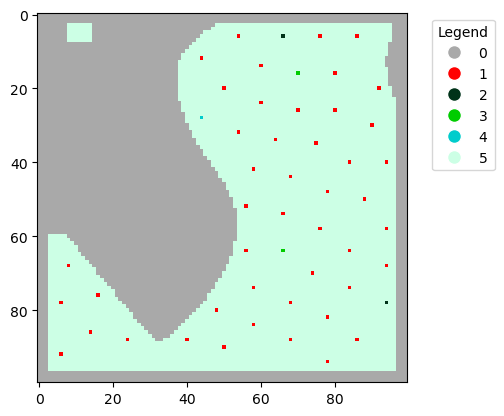

In [175]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = spatialEnv(random.uniform(1,2), 0)
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

In [176]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(octave, theme):
    def _init():
        return spatialEnv(octave, theme)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs2 = DummyVecEnv([make_env(random.uniform(1,2), random.randint(0,1)) for env in range(50)])

In [177]:
import gc
gc.collect()

49292

In [178]:
from stable_baselines3 import PPO

model = PPO("MultiInputPolicy", 
             envs2, 
             n_steps= 10,
             n_epochs= 10,
             batch_size= 10 * 50,
             verbose=0,
             tensorboard_log="./ppo_spatial_tensorboard/")

In [179]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 100000
total_timesteps = max_runs* 10

model.learn(total_timesteps=total_timesteps, progress_bar=True)
print(evaluate_policy(model, envs2, n_eval_episodes=10, warn=False))

Output()

(-498.0, 0.6324555320336759)


480


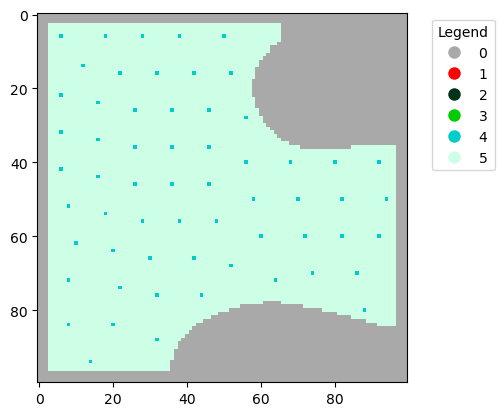

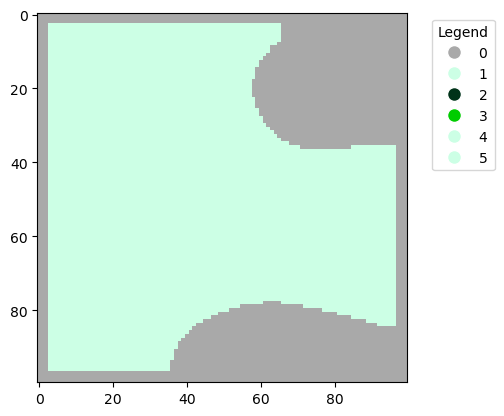

In [180]:
eval_env = spatialEnv(random.uniform(1,2), 1)
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()        
        eval_env.render(True)
        break

254


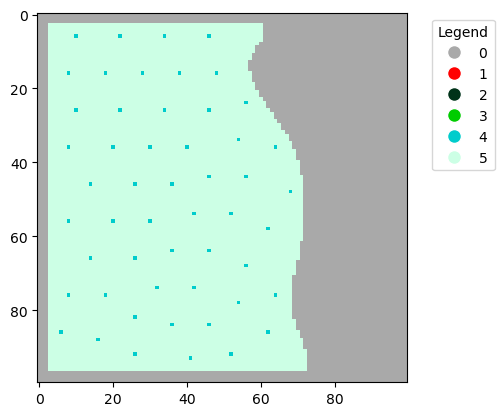

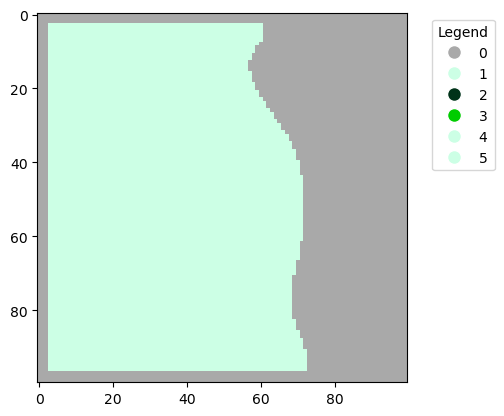

In [181]:
eval_env = spatialEnv(random.uniform(1,2), 0)
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()        
        eval_env.render(True)
        break

In [253]:
model.save('models/TEST1.zip')

### SECOND TESTING (TEST2)

In [215]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass

class rewardEnv(gym.Env):
    def __init__(self, octave:float, theme:int, grid_size:tuple=(100,100)):
        """
            Args:
                context (int): either 0 or 1, 0 for roads while 1 for walkways
                octave (float): octave value from range [1-2] for perlin noise
                grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(rewardEnv, self).__init__()

        # Steps
        self.current_step = 0
        self.max_step = 250

        # Base Variables
        self.minimum_distance = 10
        self.tree_distance = 50
        self.padded_boundary = 5
        self.contour_distance = 5
        self.theme = theme
        
        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()

        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)

        # Observation space
        self.observation_space = spaces.Box(low=-1, high=10, shape=(self.maximum_planting_spots, 3), dtype=np.float32)

        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([self.maximum_planting_spots, 3])


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed= random.randint(0,50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())
            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid
    

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates    
    
    
    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid
    

    def _distance_from_centre(self):
        labeled_array, num_features = label(self.filled_boundary)
        # Prepare an array to store distances from the center of each area
        distance_from_center = np.zeros_like(self.filled_boundary, dtype=float)

        # For each labeled component, calculate distances from the centroid
        for label_num in range(1, num_features + 1):
            # Find the centroid of the current component
            centroid = center_of_mass(self.filled_boundary, labeled_array, label_num)
            # Create a mask for the current component
            mask = labeled_array == label_num
            # Get the coordinates of points in the current component
            coords = np.argwhere(mask)
            # Calculate distances from the centroid for each point in the component
            for coord in coords:
                distance = np.sqrt((coord[0] - centroid[0])**2 + (coord[1] - centroid[1])**2)
                distance_from_center[tuple(coord)] = distance

        # Round distances to the nearest integer
        return distance_from_center
    

    def _get_contour(self, grid_distance, xcoord, ycoord):
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0) 
        # if chosen_contour <= 1:
        #     near_boundary = 1
        # else:
        #     near_boundary = 0       
        return chosen_contour, coordinate_distance
        

    def _embed_coordinates(self, planting_coordinates:np.ndarray):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        # Padded
        normalised_planting_list = np.full(((self.maximum_planting_spots), 7), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        curve_data = []

        if self.theme == 0:
            # Boundary
            grid_distance  = self._distance_from_centre()
        else:
            grid_distance =  distance_transform_edt(self.filled_boundary)

        curve_distance = distance_transform_edt(self.filled_boundary)
        min_tree_distance = (grid_distance.max() -  grid_distance.min())*0.3 + grid_distance.min()
        max_contour = grid_distance.max()//self.contour_distance + (1 if grid_distance.max()%self.contour_distance > self.contour_distance/2 else 0)

        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            # Update data
            contour, coord_dist = self._get_contour(grid_distance, planting_coords[1], planting_coords[0])
            curve_contour, curve_dist = self._get_contour(curve_distance, planting_coords[1], planting_coords[0])
            curve_data.append([curve_contour, curve_dist])

            # making tree plantable 7 if near curve & distance, else 5 or -1
            tree_plantable = 5 if coord_dist >= min_tree_distance else -1
            
            if self.theme == 0:
                # Boundary, additional requirements to get 2 
                # Shrub closer to center is 3, away from first round of boundary is 2
                na_plantable = 2
                shrub_plantable = 2

                # Near boundary, no shrub but na plantable
                if curve_contour <= 1:
                    shrub_plantable = 0
                    na_plantable = 3
                
                elif coord_dist <= min_tree_distance:
                    shrub_plantable = 3
                    na_plantable = 0

            else:
                # Walkway no score
                shrub_plantable = 2 
                na_plantable = 2 
            
            normalised_planting_list[i] = (planting_coords[1], planting_coords[0], round(coord_dist), curve_dist, tree_plantable, shrub_plantable, na_plantable)

        # Near curve?
        # Find unique contours and their indices in curve array
        unique_contours, indices, counts = np.unique(np.array(curve_data), axis=0, return_inverse=True, return_counts=True)
        # Duplicated length likely to be at straight line
        is_duplicate = counts[indices] > 1
        normalised_planting_list[:len(planting_coordinates), 3] = np.where(is_duplicate, 0, 1)

        # Update tree score, if near curve and tree plantable score becomes 7
        normalised_planting_list[(normalised_planting_list[:, 3] == 1) & (normalised_planting_list[:, 4] == 5), 4] = 7

        self.result_grid = normalised_planting_list[:, 4:]

        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return self.result_grid


    def reset(self, seed=None, options=None):
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)
        self.current_step = 0
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)
        return self._get_observation() , {}
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-4] = -1
                self.result_grid[index][0] = -1


    def step(self, action):
        self.current_step +=  1
        reward = 0
        
        # Decode action
        chosen_index = action[0]
        class_value = action[1]
        chosen_value = self.normalised_planting_list[chosen_index]

        reward = self.result_grid[chosen_index, class_value]

        if reward >= 0:

            if class_value == 0:
                self.tree_coordinates.append((chosen_value[1], chosen_value[0]))
                self._update_tree_distance()            
            # Successful planting 
            # update grid
            self.grid[chosen_value[1], chosen_value[0]] = class_value + 2
            self.class_count[class_value] += 1
            # Update result grid
            self.result_grid[chosen_index, :] = -1
            self._update_density_reward()
        
        # print(reward, action)
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -1], [-1]))) or self.current_step >= self.max_step
        return self._get_observation(), float(reward), done ,False, {}


    def _update_density_reward(self):
        total_count = sum(self.class_count.values())
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density

        density_ratios = [0.6, 0.3]
        
        for index, class_index in enumerate([1, 2]):
            mask = self.result_grid[:, class_index] != -1  # Create a mask for values not equal to -1
            # Shrub is -2 in normalised_planting_list, NA is -1, class index is 1 and 2 so -3+classindex
            self.result_grid[mask, class_index] = self.normalised_planting_list[mask, (-3+class_index)]*(np.exp(-(self.class_density[class_index])/density_ratios[index])**3)  # Apply exponential function
        

    def render(self, only_plant:bool=False, show_coord:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        img = np.zeros((100, 100, 3))
        for value, color in value_to_colour.items():
            img[self.grid == value] = color
        
        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]

        if show_coord:
            plt.figure(figsize=(12, 12))

            # Plot each coordinate and label them with [a,b]
            for i, coord in enumerate(self.normalised_planting_list):
                x, y, d, nc, tp, sp, nap= coord
                ts,ss,nas = self.result_grid[i]
                if x == -1:
                    pass
                else:
                    # Add 0.5 to place text in the center of the cell
                    plt.text(x, y, f"{ts,ss,nas}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')


        plt.imshow(img)  # Set origin to lower to align with the grid's coordinate syste
        # Add legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.show()


[60  0]
[6 6]


c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


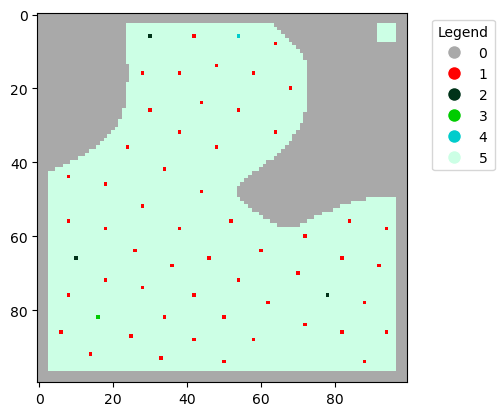

In [218]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = rewardEnv(random.uniform(1,2), 0)
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

In [219]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(octave, theme):
    def _init():
        return rewardEnv(octave, theme)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs2 = DummyVecEnv([make_env(random.uniform(1,2), random.randint(0,1)) for env in range(50)])

In [220]:
import gc
gc.collect()

38830

In [221]:
from stable_baselines3 import PPO

model = PPO("MlpPolicy", 
             envs2, 
             n_steps= 5,
             n_epochs= 5,
             batch_size= 5 * 50,
             verbose=0,
             tensorboard_log="./ppo_spatial_tensorboard/")

In [222]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 50000
total_timesteps = max_runs* 5

model.learn(total_timesteps=total_timesteps, progress_bar=True)
print(evaluate_policy(model, envs2, n_eval_episodes=10, warn=False))

Output()

(-246.89865241060033, 1.3019743406432556)


249


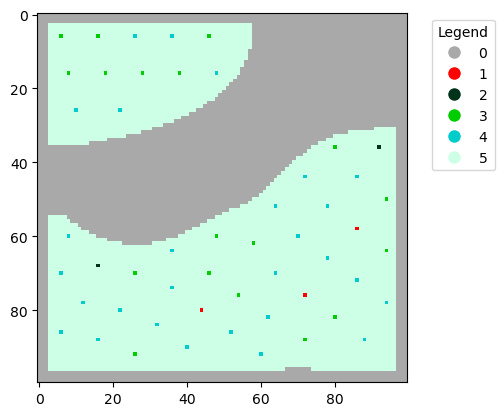

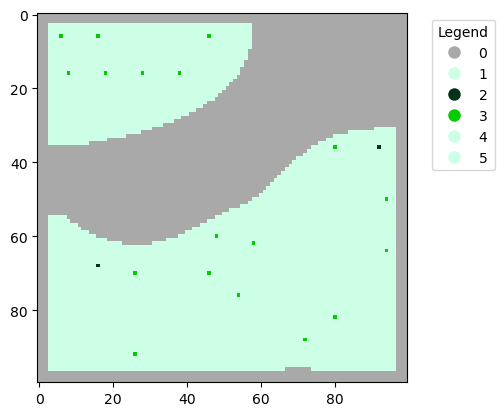

In [228]:
eval_env = rewardEnv(random.uniform(1,2), 0)
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(500):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()        
        eval_env.render(True)
        break

249


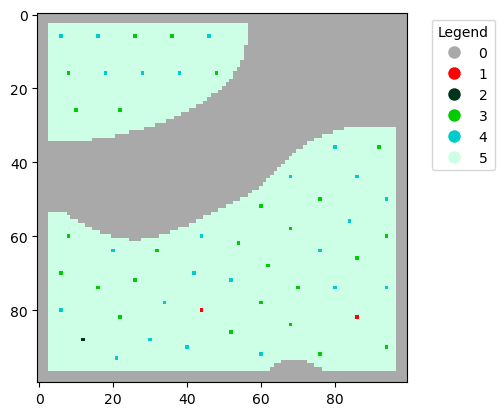

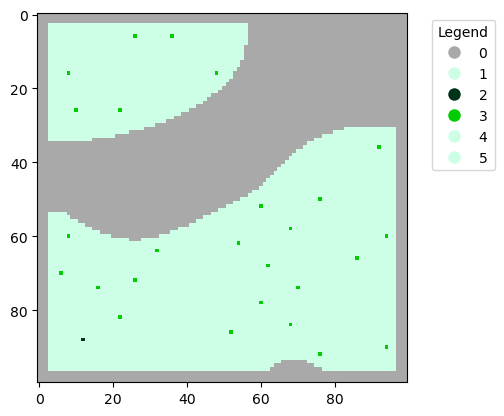

In [227]:
eval_env = rewardEnv(random.uniform(1,2), 1)
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(500):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()        
        eval_env.render(True)
        break

In [229]:
model.save('models/TEST2.zip')

### Trying adding Tree Count? How many trees will be plantable spots left if this spot is used (TEST3)

In [393]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass

class updatedRewardEnv(gym.Env):
    def __init__(self, octave:float, theme:int, grid_size:tuple=(100,100)):
        """
            Args:
                context (int): either 0 or 1, 0 for roads while 1 for walkways
                octave (float): octave value from range [1-2] for perlin noise
                grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(updatedRewardEnv, self).__init__()

        # Steps
        self.current_step = 0
        self.max_step = 250

        # Base Variables
        self.minimum_distance = 10
        self.tree_distance = 50
        self.padded_boundary = 5
        self.contour_distance = 5
        self.theme = theme
        
        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)

        # Embedding planting coordinates and padding
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)

        # Observation space
        self.observation_space = spaces.Box(low=-1, high=100, shape=(self.maximum_planting_spots, 3), dtype=np.float32)

        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([self.maximum_planting_spots, 3])


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed= random.randint(0,50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())
            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid
    

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates    
    
    
    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid
    

    def _distance_from_centre(self):
        labeled_array, num_features = label(self.filled_boundary)
        # Prepare an array to store distances from the center of each area
        distance_from_center = np.zeros_like(self.filled_boundary, dtype=float)

        # For each labeled component, calculate distances from the centroid
        for label_num in range(1, num_features + 1):
            # Find the centroid of the current component
            centroid = center_of_mass(self.filled_boundary, labeled_array, label_num)
            # Create a mask for the current component
            mask = labeled_array == label_num
            # Get the coordinates of points in the current component
            coords = np.argwhere(mask)
            # Calculate distances from the centroid for each point in the component
            for coord in coords:
                distance = np.sqrt((coord[0] - centroid[0])**2 + (coord[1] - centroid[1])**2)
                distance_from_center[tuple(coord)] = distance

        # Round distances to the nearest integer
        return distance_from_center
    

    def _get_contour(self, grid_distance, xcoord, ycoord):
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0) 
        # if chosen_contour <= 1:
        #     near_boundary = 1
        # else:
        #     near_boundary = 0       
        return chosen_contour, coordinate_distance
        

    def _remaining_plantable_tree_count(self, xcoord, ycoord):
        new_tree_coordinates = np.array(self.tree_coordinates + [[ycoord, xcoord]])
        coordinate_distances = cdist(self.planting_coordinates, new_tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)
        return np.sum(min_distances >= 50)
    

    def _embed_coordinates(self, planting_coordinates:np.ndarray):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        # Padded
        normalised_planting_list = np.full(((self.maximum_planting_spots), 8), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        curve_data = []

        if self.theme == 0:
            # Boundary
            grid_distance  = self._distance_from_centre()
        else:
            grid_distance =  distance_transform_edt(self.filled_boundary)

        curve_distance = distance_transform_edt(self.filled_boundary)
        min_tree_distance = (grid_distance.max() -  grid_distance.min())*0.3 + grid_distance.min()
        max_contour = grid_distance.max()//self.contour_distance + (1 if grid_distance.max()%self.contour_distance > self.contour_distance/2 else 0)

        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            # Update data
            contour, coord_dist = self._get_contour(grid_distance, planting_coords[1], planting_coords[0])
            curve_contour, curve_dist = self._get_contour(curve_distance, planting_coords[1], planting_coords[0])
            curve_data.append([curve_contour, curve_dist])
            remaining_plantable_trees = self._remaining_plantable_tree_count(planting_coords[1], planting_coords[0])
            # making tree plantable 7 if near curve & distance, else 5 or -1
            tree_plantable = 2 if coord_dist >= min_tree_distance else -1
            
            if self.theme == 0:
                # Boundary, additional requirements to get 2 
                # Shrub closer to center is 3, away from first round of boundary is 2
                na_plantable = 2
                shrub_plantable = 2

                # Near boundary, no shrub but na plantable
                if curve_contour <= 1:
                    shrub_plantable = 0
                    na_plantable = 3
                
                elif coord_dist <= min_tree_distance:
                    shrub_plantable = 3
                    na_plantable = 0

            else:
                # Walkway no score
                shrub_plantable = 2 
                na_plantable = 2 
            
            normalised_planting_list[i] = (planting_coords[1], planting_coords[0], round(coord_dist), curve_dist, remaining_plantable_trees, tree_plantable, shrub_plantable, na_plantable)

        # Near curve?
        # Find unique contours and their indices in curve array
        unique_contours, indices, counts = np.unique(np.array(curve_data), axis=0, return_inverse=True, return_counts=True)
        # Duplicated length likely to be at straight line
        is_duplicate = counts[indices] > 1
        normalised_planting_list[:len(planting_coordinates), 3] = np.where(is_duplicate, 0, 1)

        # Update tree score, if near curve and tree plantable score becomes 7
        normalised_planting_list[(normalised_planting_list[:, 3] == 1) & (normalised_planting_list[:, 5] == 2), 5] = 3

        # Sum the tree plantable &  together
        normalised_planting_list[:, 5] = np.where(
            normalised_planting_list[:, 5] != -1,  # Condition: 5th index is not -1
            np.where(normalised_planting_list[:, 5] > 0,  # Check for valid log input
                    normalised_planting_list[:, 4] + (np.log(normalised_planting_list[:, 5])*2),  # Valid log operation
                    normalised_planting_list[:, 5]),  # Keep original value if not valid
            normalised_planting_list[:, 5]  # Remains unchanged if 5th index is -1
        )
        
        self.result_grid = normalised_planting_list[:, 5:]

        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return self.result_grid


    def reset(self, seed=None, options=None):
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)
        self.current_step = 0
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)
        return self._get_observation() , {}


    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-4] = -1
                self.result_grid[index][0] = -1


    def step(self, action):
        self.current_step +=  1
        reward = 0
        
        # Decode action
        chosen_index = action[0]
        class_value = action[1]
        chosen_value = self.normalised_planting_list[chosen_index]

        reward = self.result_grid[chosen_index, class_value]

        if reward >= 0:

            if class_value == 0:
                self.tree_coordinates.append((chosen_value[1], chosen_value[0]))
                self._update_tree_distance()            
            # Successful planting 
            # update grid
            self.grid[chosen_value[1], chosen_value[0]] = class_value + 2
            self.class_count[class_value] += 1
            # Update result grid
            self.result_grid[chosen_index, :] = -1
            self._update_density_reward()
        
        # print(reward, action)
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -1], [-1]))) or self.current_step >= self.max_step
        return self._get_observation(), float(reward), done ,False, {}


    def _update_density_reward(self):
        total_count = sum(self.class_count.values())
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density

        density_ratios = [0.6, 0.35]
        
        for index, class_index in enumerate([1, 2]):
            mask = self.result_grid[:, class_index] != -1  # Create a mask for values not equal to -1
            # Shrub is -2 in normalised_planting_list, NA is -1, class index is 1 and 2 so -3+classindex
            self.result_grid[mask, class_index] = self.normalised_planting_list[mask, (-3+class_index)]*(np.exp(-(self.class_density[class_index])/density_ratios[index])**3)  # Apply exponential function
        

    def render(self, only_plant:bool=False, show_coord:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        img = np.zeros((100, 100, 3))
        for value, color in value_to_colour.items():
            img[self.grid == value] = color
        
        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]

        if show_coord:
            plt.figure(figsize=(12, 12))

            # Plot each coordinate and label them with [a,b]
            for i, coord in enumerate(self.normalised_planting_list):
                x, y, d, nc, tp, sp, nap= coord
                ts,ss,nas = self.result_grid[i]
                if x == -1:
                    pass
                else:
                    # Add 0.5 to place text in the center of the cell
                    plt.text(x, y, f"{ts,ss,nas}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')


        plt.imshow(img)  # Set origin to lower to align with the grid's coordinate syste
        # Add legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.show()


###  TEST 4 (8) & 5 (12)

In [394]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass

class updatedRewardEnv(gym.Env):
    def __init__(self, octave:float, theme:int, grid_size:tuple=(100,100)):
        """
            Args:
                context (int): either 0 or 1, 0 for roads while 1 for walkways
                octave (float): octave value from range [1-2] for perlin noise
                grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(updatedRewardEnv, self).__init__()

        # Steps
        self.current_step = 0
        self.max_step = 250

        # Base Variables
        self.minimum_distance = 10
        self.tree_distance = 50
        self.padded_boundary = 5
        self.contour_distance = 5
        self.theme = theme
        
        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)

        # Embedding planting coordinates and padding
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)

        # Observation space
        self.observation_space = spaces.Box(low=-1, high=100, shape=(self.maximum_planting_spots, 3), dtype=np.float32)

        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([self.maximum_planting_spots, 3])


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed= random.randint(0,50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())
            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid
    

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates    
    
    
    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid
    

    def _distance_from_centre(self):
        labeled_array, num_features = label(self.filled_boundary)
        # Prepare an array to store distances from the center of each area
        distance_from_center = np.zeros_like(self.filled_boundary, dtype=float)

        # For each labeled component, calculate distances from the centroid
        for label_num in range(1, num_features + 1):
            # Find the centroid of the current component
            centroid = center_of_mass(self.filled_boundary, labeled_array, label_num)
            # Create a mask for the current component
            mask = labeled_array == label_num
            # Get the coordinates of points in the current component
            coords = np.argwhere(mask)
            # Calculate distances from the centroid for each point in the component
            for coord in coords:
                distance = np.sqrt((coord[0] - centroid[0])**2 + (coord[1] - centroid[1])**2)
                distance_from_center[tuple(coord)] = distance

        # Round distances to the nearest integer
        return distance_from_center
    

    def _get_contour(self, grid_distance, xcoord, ycoord):
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0) 
        # if chosen_contour <= 1:
        #     near_boundary = 1
        # else:
        #     near_boundary = 0       
        return chosen_contour, coordinate_distance
        

    def _remaining_plantable_tree_count(self, xcoord, ycoord):
        new_tree_coordinates = np.array(self.tree_coordinates + [[ycoord, xcoord]])
        coordinate_distances = cdist(self.planting_coordinates, new_tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)
        return np.sum(min_distances >= 50)
    

    def _embed_coordinates(self, planting_coordinates:np.ndarray):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        # Padded
        normalised_planting_list = np.full(((self.maximum_planting_spots), 8), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        curve_data = []

        if self.theme == 0:
            # Boundary
            grid_distance  = self._distance_from_centre()
        else:
            grid_distance =  distance_transform_edt(self.filled_boundary)

        curve_distance = distance_transform_edt(self.filled_boundary)
        min_tree_distance = (grid_distance.max() -  grid_distance.min())*0.3 + grid_distance.min()
        max_contour = grid_distance.max()//self.contour_distance + (1 if grid_distance.max()%self.contour_distance > self.contour_distance/2 else 0)

        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            # Update data
            contour, coord_dist = self._get_contour(grid_distance, planting_coords[1], planting_coords[0])
            curve_contour, curve_dist = self._get_contour(curve_distance, planting_coords[1], planting_coords[0])
            curve_data.append([curve_contour, curve_dist])
            remaining_plantable_trees = self._remaining_plantable_tree_count(planting_coords[1], planting_coords[0])
            # making tree plantable 7 if near curve & distance, else 5 or -1
            tree_plantable = 2 if coord_dist >= min_tree_distance else -1
            
            if self.theme == 0:
                # Boundary, additional requirements to get 2 
                # Shrub closer to center is 3, away from first round of boundary is 2
                na_plantable = 1
                shrub_plantable = 2

                # Near boundary, no shrub but na plantable
                if curve_contour <= 1:
                    shrub_plantable = -1
                    na_plantable = 3
                
                elif coord_dist <= min_tree_distance:
                    shrub_plantable = 3

            else:
                # Walkway no score
                shrub_plantable = 2 
                na_plantable = 1 
            
            normalised_planting_list[i] = (planting_coords[1], planting_coords[0], round(coord_dist), curve_dist, remaining_plantable_trees, tree_plantable, shrub_plantable, na_plantable)

        # Near curve?
        # Find unique contours and their indices in curve array
        unique_contours, indices, counts = np.unique(np.array(curve_data), axis=0, return_inverse=True, return_counts=True)
        # Duplicated length likely to be at straight line
        is_duplicate = counts[indices] > 1
        normalised_planting_list[:len(planting_coordinates), 3] = np.where(is_duplicate, 0, 1)

        # Update tree score, if near curve and tree plantable score becomes 7
        normalised_planting_list[(normalised_planting_list[:, 3] == 1) & (normalised_planting_list[:, 5] == 2), 5] = 3

        # Sum the tree plantable &  together
        normalised_planting_list[:, 5] = np.where(
            normalised_planting_list[:, 5] != -1,  # Condition: 5th index is not -1
            np.where(normalised_planting_list[:, 5] > 0,  # Check for valid log input
                    normalised_planting_list[:, 4] + (np.log(normalised_planting_list[:, 5])*2),  # Valid log operation
                    normalised_planting_list[:, 5]),  # Keep original value if not valid
            normalised_planting_list[:, 5]  # Remains unchanged if 5th index is -1
        )
        
        self.result_grid = normalised_planting_list[:, 5:]

        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return self.result_grid


    def reset(self, seed=None, options=None):
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)
        self.current_step = 0
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)
        return self._get_observation() , {}


    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-4] = -1
                self.result_grid[index][0] = -1


    def step(self, action):
        self.current_step +=  1
        reward = 0
        
        # Decode action
        chosen_index = action[0]
        class_value = action[1]
        chosen_value = self.normalised_planting_list[chosen_index]

        reward = self.result_grid[chosen_index, class_value]

        if reward >= 0:
            if class_value == 0:
                self.tree_coordinates.append((chosen_value[1], chosen_value[0]))
                self._update_tree_distance()            
            # Successful planting 
            # update grid
            self.grid[chosen_value[1], chosen_value[0]] = class_value + 2
            self.class_count[class_value] += 1
            # Update result grid
            self.result_grid[chosen_index, :] = -1
            self._update_density_reward()
        
        # print(reward, action)
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -1], [-1]))) or self.current_step >= self.max_step
        return self._get_observation(), float(reward), done ,False, {}


    def _update_density_reward(self):
        total_count = sum(self.class_count.values())
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density

        density_ratios = [0.6, 0.35]
        
        for index, class_index in enumerate([1, 2]):
            mask = self.result_grid[:, class_index] != -1  # Create a mask for values not equal to -1
            # Shrub is -2 in normalised_planting_list, NA is -1, class index is 1 and 2 so -3+classindex
            self.result_grid[mask, class_index] = self.normalised_planting_list[mask, (-3+class_index)]*(np.exp(-(self.class_density[class_index])/density_ratios[index])**3)  # Apply exponential function
        

    def render(self, only_plant:bool=False, show_coord:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        img = np.zeros((100, 100, 3))
        for value, color in value_to_colour.items():
            img[self.grid == value] = color
        
        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]

        if show_coord:
            plt.figure(figsize=(12, 12))

            # Plot each coordinate and label them with [a,b]
            for i, coord in enumerate(self.normalised_planting_list):
                x, y, d, nc, tp, sp, nap= coord
                ts,ss,nas = self.result_grid[i]
                if x == -1:
                    pass
                else:
                    # Add 0.5 to place text in the center of the cell
                    plt.text(x, y, f"{ts,ss,nas}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')


        plt.imshow(img)  # Set origin to lower to align with the grid's coordinate syste
        # Add legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.show()


### exploring further  (TEST 6 - can plant shrubs & 7 -shrubs -1 = no shrubs)

In [516]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass

class updatedRewardEnv(gym.Env):
    def __init__(self, octave:float, theme:int, seed:int=None, grid_size:tuple=(100,100)):
        """
            Args:
                context (int): either 0 or 1, 0 for roads while 1 for walkways
                octave (float): octave value from range [1-2] for perlin noise
                grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(updatedRewardEnv, self).__init__()

        # Steps
        self.current_step = 0
        self.max_step = 250

        # Base Variables
        self.minimum_distance = 10
        self.tree_distance = 50
        self.padded_boundary = 5
        self.contour_distance = 5
        self.theme = theme
        self.seed = seed
        
        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)

        # Embedding planting coordinates and padding
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)

        # Observation space
        self.observation_space = spaces.Box(low=-1, high=100, shape=(self.maximum_planting_spots, 3), dtype=np.float32)

        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([self.maximum_planting_spots, 3])


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed= self.seed if self.seed is not None else random.randint(0,50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())
            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid
    

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates    
    
    
    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid
    

    def _distance_from_centre(self):
        labeled_array, num_features = label(self.filled_boundary)
        # Prepare an array to store distances from the center of each area
        distance_from_center = np.zeros_like(self.filled_boundary, dtype=float)

        # For each labeled component, calculate distances from the centroid
        for label_num in range(1, num_features + 1):
            # Find the centroid of the current component
            centroid = center_of_mass(self.filled_boundary, labeled_array, label_num)
            # Create a mask for the current component
            mask = labeled_array == label_num
            # Get the coordinates of points in the current component
            coords = np.argwhere(mask)
            # Calculate distances from the centroid for each point in the component
            for coord in coords:
                distance = np.sqrt((coord[0] - centroid[0])**2 + (coord[1] - centroid[1])**2)
                distance_from_center[tuple(coord)] = distance

        # Round distances to the nearest integer
        return distance_from_center
    

    def _get_contour(self, grid_distance, xcoord, ycoord):
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0) 
        # if chosen_contour <= 1:
        #     near_boundary = 1
        # else:
        #     near_boundary = 0       
        return chosen_contour, coordinate_distance
        

    def _remaining_plantable_tree_count(self, xcoord, ycoord):
        new_tree_coordinates = np.array(self.tree_coordinates + [[ycoord, xcoord]])
        coordinate_distances = cdist(self.planting_coordinates, new_tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)
        return np.log(np.sum(min_distances >= 50)) if np.sum(min_distances >= 50) > 0 else 0
    

    def _embed_coordinates(self, planting_coordinates:np.ndarray):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        # Padded
        normalised_planting_list = np.full(((self.maximum_planting_spots), 9), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        curve_data = []

        if self.theme == 0:
            # Boundary
            grid_distance  = self._distance_from_centre()
        else:
            grid_distance =  distance_transform_edt(self.filled_boundary)

        curve_distance = distance_transform_edt(self.filled_boundary)
        min_tree_distance = (grid_distance.max() -  grid_distance.min())*0.3 + grid_distance.min()
        max_contour = grid_distance.max()//self.contour_distance + (1 if grid_distance.max()%self.contour_distance > self.contour_distance/2 else 0)

        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            # Update data
            contour, coord_dist = self._get_contour(grid_distance, planting_coords[1], planting_coords[0])
            curve_contour, curve_dist = self._get_contour(curve_distance, planting_coords[1], planting_coords[0])
            curve_data.append([curve_contour, curve_dist])
            remaining_plantable_trees = self._remaining_plantable_tree_count(planting_coords[1], planting_coords[0])
            # making tree plantable 7 if near curve & distance, else 5 or -1
            tree_plantable = 2 if coord_dist >= min_tree_distance else -1
            
            if self.theme == 0:
                # Boundary, additional requirements to get 2 
                # Shrub closer to center is 3, away from first round of boundary is 2
                na_plantable = 1
                shrub_plantable = 2

                # Near boundary, no shrub but na plantable
                if curve_contour <= 1:
                    shrub_plantable = 0
                    na_plantable = 3
                
                elif coord_dist <= min_tree_distance:
                    shrub_plantable = 3

            else:
                # Walkway no score
                shrub_plantable = 2 
                na_plantable = 1 
            
            normalised_planting_list[i] = (planting_coords[1], planting_coords[0], round(coord_dist), curve_dist, remaining_plantable_trees, tree_plantable, tree_plantable, shrub_plantable, na_plantable)

        # Near curve?
        # Find unique contours and their indices in curve array
        unique_contours, indices, counts = np.unique(np.array(curve_data), axis=0, return_inverse=True, return_counts=True)
        # Duplicated length likely to be at straight line
        is_duplicate = counts[indices] > 1
        normalised_planting_list[:len(planting_coordinates), 3] = np.where(is_duplicate, 0, 1)

        # Update tree score, if near curve and tree plantable score becomes 7
        normalised_planting_list[(normalised_planting_list[:, 3] == 1) & (normalised_planting_list[:, 5] == 2), 5] = 3

        # Sum the tree plantable & together
        normalised_planting_list[:, 6] = np.where(
            normalised_planting_list[:, 6] != -1,  # Condition: 6th index is not -
            normalised_planting_list[:, 4] + normalised_planting_list[:, 5],  # Valid log operation
            normalised_planting_list[:, 6]  # Remains unchanged if 6th index is -1
        )
        
        self.result_grid = normalised_planting_list[:, 6:]

        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return self.result_grid


    def reset(self, seed=None, options=None):
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)
        self.current_step = 0
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)
        return self._get_observation() , {}


    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-4] = -1
                self.result_grid[index][0] = -1

        for index, result_row in enumerate(self.result_grid):
            if result_row[0] != -1:
                remaining_plantable_trees = self._remaining_plantable_tree_count(self.normalised_planting_list[index][0], self.normalised_planting_list[index][1])
                result_row[0] = remaining_plantable_trees + self.normalised_planting_list[index][5]


    def step(self, action):
        self.current_step +=  1
        reward = 0
        
        # Decode action
        chosen_index = action[0]
        class_value = action[1]
        chosen_value = self.normalised_planting_list[chosen_index]

        reward = self.result_grid[chosen_index, class_value]

        if reward >= 0:
            if class_value == 0:
                self.tree_coordinates.append((chosen_value[1], chosen_value[0]))
                self._update_tree_distance()       
            # Successful planting 
            # update grid
            self.grid[chosen_value[1], chosen_value[0]] = class_value + 2
            self.class_count[class_value] += 1
            # Update result grid
            self.result_grid[chosen_index, :] = -1
            self._update_density_reward()
        
        # print(reward, action)
        done = bool(np.all(np.isin(self.result_grid[:, -1], [-1]))) or self.current_step >= self.max_step
        return self._get_observation(), float(reward), done ,False, {}


    def _update_density_reward(self):
        total_count = sum(self.class_count.values())
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density

        density_ratios = [0.6, 0.25]
        
        for index, class_index in enumerate([1, 2]):
            mask = self.result_grid[:, class_index] != -1  # Create a mask for values not equal to -1
            # Shrub is -2 in normalised_planting_list, NA is -1, class index is 1 and 2 so -3+classindex
            self.result_grid[mask, class_index] = self.normalised_planting_list[mask, (-3+class_index)]*(np.exp(-(self.class_density[class_index])/density_ratios[index])**3)  # Apply exponential function
        

    def render(self, only_plant:bool=False, show_coord:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        img = np.zeros((100, 100, 3))
        for value, color in value_to_colour.items():
            img[self.grid == value] = color
        
        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]

        if show_coord:
            plt.figure(figsize=(12, 12))

            # Plot each coordinate and label them with [a,b]
            for i, coord in enumerate(self.normalised_planting_list):
                x, y, d, nc, tp, sp, nap= coord
                ts,ss,nas = self.result_grid[i]
                if x == -1:
                    pass
                else:
                    # Add 0.5 to place text in the center of the cell
                    plt.text(x, y, f"{ts,ss,nas}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')


        plt.imshow(img)  # Set origin to lower to align with the grid's coordinate syste
        # Add legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.show()


### additional  shrub  reward

In [ ]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass

class updatedRewardEnv(gym.Env):
    def __init__(self, octave:float, theme:int, seed:int=None, grid_size:tuple=(100,100)):
        """
            Args:
                context (int): either 0 or 1, 0 for roads while 1 for walkways
                octave (float): octave value from range [1-2] for perlin noise
                grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(updatedRewardEnv, self).__init__()

        # Steps
        self.current_step = 0
        self.max_step = 250

        # Base Variables
        self.minimum_distance = 10
        self.tree_distance = 50
        self.padded_boundary = 5
        self.contour_distance = 5
        self.theme = theme
        self.seed = seed
        
        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)

        # Embedding planting coordinates and padding
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)

        # Observation space
        self.observation_space = spaces.Box(low=-1, high=100, shape=(self.maximum_planting_spots, 3), dtype=np.float32)

        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([self.maximum_planting_spots, 3])


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed= self.seed if self.seed is not None else random.randint(0,50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())
            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid
    

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates    
    
    
    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid
    

    def _distance_from_centre(self):
        labeled_array, num_features = label(self.filled_boundary)
        # Prepare an array to store distances from the center of each area
        distance_from_center = np.zeros_like(self.filled_boundary, dtype=float)

        # For each labeled component, calculate distances from the centroid
        for label_num in range(1, num_features + 1):
            # Find the centroid of the current component
            centroid = center_of_mass(self.filled_boundary, labeled_array, label_num)
            # Create a mask for the current component
            mask = labeled_array == label_num
            # Get the coordinates of points in the current component
            coords = np.argwhere(mask)
            # Calculate distances from the centroid for each point in the component
            for coord in coords:
                distance = np.sqrt((coord[0] - centroid[0])**2 + (coord[1] - centroid[1])**2)
                distance_from_center[tuple(coord)] = distance

        # Round distances to the nearest integer
        return distance_from_center
    

    def _get_contour(self, grid_distance, xcoord, ycoord):
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0) 
        # if chosen_contour <= 1:
        #     near_boundary = 1
        # else:
        #     near_boundary = 0       
        return chosen_contour, coordinate_distance
        

    def _remaining_plantable_tree_count(self, xcoord, ycoord):
        new_tree_coordinates = np.array(self.tree_coordinates + [[ycoord, xcoord]])
        coordinate_distances = cdist(self.planting_coordinates, new_tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)
        return np.log(np.sum(min_distances >= 50)) if np.sum(min_distances >= 50) > 0 else 0
    

    def _embed_coordinates(self, planting_coordinates:np.ndarray):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        # Padded
        normalised_planting_list = np.full(((self.maximum_planting_spots), 9), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        curve_data = []

        if self.theme == 0:
            # Boundary
            grid_distance  = self._distance_from_centre()
        else:
            grid_distance =  distance_transform_edt(self.filled_boundary)

        curve_distance = distance_transform_edt(self.filled_boundary)
        min_tree_distance = (grid_distance.max() -  grid_distance.min())*0.3 + grid_distance.min()
        max_contour = grid_distance.max()//self.contour_distance + (1 if grid_distance.max()%self.contour_distance > self.contour_distance/2 else 0)

        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            # Update data
            contour, coord_dist = self._get_contour(grid_distance, planting_coords[1], planting_coords[0])
            curve_contour, curve_dist = self._get_contour(curve_distance, planting_coords[1], planting_coords[0])
            curve_data.append([curve_contour, curve_dist])
            remaining_plantable_trees = self._remaining_plantable_tree_count(planting_coords[1], planting_coords[0])
            # making tree plantable 7 if near curve & distance, else 5 or -1
            tree_plantable = 2 if coord_dist >= min_tree_distance else -1
            
            if self.theme == 0:
                # Boundary, additional requirements to get 2 
                # Shrub closer to center is 3, away from first round of boundary is 2
                na_plantable = 1
                shrub_plantable = 2

                # Near boundary, no shrub but na plantable
                if curve_contour <= 1:
                    shrub_plantable = 0
                    na_plantable = 3
                
                elif coord_dist <= min_tree_distance:
                    shrub_plantable = 3

            else:
                shrub_plantable = 2 
                na_plantable = 1 
                # Walkway shrub near boundary ideal
                if curve_contour <= 2:
                    shrub_plantable = 3
                    na_plantable = 0

            
            normalised_planting_list[i] = (planting_coords[1], planting_coords[0], round(coord_dist), curve_dist, remaining_plantable_trees, tree_plantable, tree_plantable, shrub_plantable, na_plantable)

        # Near curve?
        # Find unique contours and their indices in curve array
        unique_contours, indices, counts = np.unique(np.array(curve_data), axis=0, return_inverse=True, return_counts=True)
        # Duplicated length likely to be at straight line
        is_duplicate = counts[indices] > 1
        normalised_planting_list[:len(planting_coordinates), 3] = np.where(is_duplicate, 0, 1)

        # Update tree score, if near curve and tree plantable score becomes 7
        normalised_planting_list[(normalised_planting_list[:, 3] == 1) & (normalised_planting_list[:, 5] == 2), 5] = 3

        # Sum the tree plantable & together
        normalised_planting_list[:, 6] = np.where(
            normalised_planting_list[:, 6] != -1,  # Condition: 6th index is not -
            normalised_planting_list[:, 4] + normalised_planting_list[:, 5],  # Valid log operation
            normalised_planting_list[:, 6]  # Remains unchanged if 6th index is -1
        )
        
        self.result_grid = normalised_planting_list[:, 6:]

        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return self.result_grid


    def reset(self, seed=None, options=None):
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)
        self.current_step = 0
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates)
        return self._get_observation() , {}


    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-4] = -1
                self.result_grid[index][0] = -1

        for index, result_row in enumerate(self.result_grid):
            if result_row[0] != -1:
                remaining_plantable_trees = self._remaining_plantable_tree_count(self.normalised_planting_list[index][0], self.normalised_planting_list[index][1])
                result_row[0] = remaining_plantable_trees + self.normalised_planting_list[index][5]


    def step(self, action):
        self.current_step +=  1
        reward = 0
        
        # Decode action
        chosen_index = action[0]
        class_value = action[1]
        chosen_value = self.normalised_planting_list[chosen_index]

        reward = self.result_grid[chosen_index, class_value]

        if reward >= 0:
            if class_value == 0:
                self.tree_coordinates.append((chosen_value[1], chosen_value[0]))
                self._update_tree_distance()       
            # Successful planting 
            # update grid
            self.grid[chosen_value[1], chosen_value[0]] = class_value + 2
            self.class_count[class_value] += 1
            # Update result grid
            self.result_grid[chosen_index, :] = -1
            self._update_density_reward()
        
        # print(reward, action)
        done = bool(np.all(np.isin(self.result_grid[:, -1], [-1]))) or self.current_step >= self.max_step
        return self._get_observation(), float(reward), done ,False, {}


    def _update_density_reward(self):
        total_count = sum(self.class_count.values())
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density

        density_ratios = [0.65, 0.35]
        
        for index, class_index in enumerate([1, 2]):
            mask = self.result_grid[:, class_index] != -1  # Create a mask for values not equal to -1
            # Shrub is -2 in normalised_planting_list, NA is -1, class index is 1 and 2 so -3+classindex
            self.result_grid[mask, class_index] = self.normalised_planting_list[mask, (-3+class_index)]*(np.exp(-(self.class_density[class_index])/density_ratios[index])**3)  # Apply exponential function
        

    def render(self, only_plant:bool=False, show_coord:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        img = np.zeros((100, 100, 3))
        for value, color in value_to_colour.items():
            img[self.grid == value] = color
        
        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]

        if show_coord:
            plt.figure(figsize=(12, 12))

            # Plot each coordinate and label them with [a,b]
            for i, coord in enumerate(self.normalised_planting_list):
                x, y, d, nc, d2, d3, tp, sp, nap= coord
                ts,ss,nas = self.result_grid[i]
                if x == -1:
                    pass
                else:
                    # Add 0.5 to place text in the center of the cell
                    plt.text(x, y, f"{ts,ss,nas}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')


        plt.imshow(img)  # Set origin to lower to align with the grid's coordinate syste
        # Add legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.show()


In [14]:
test = updatedRewardEnv(random.uniform(1,2), 0, 2)


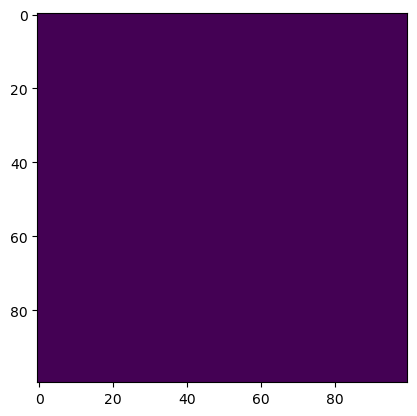

In [15]:
plt.imshow(test.filled_boundary)

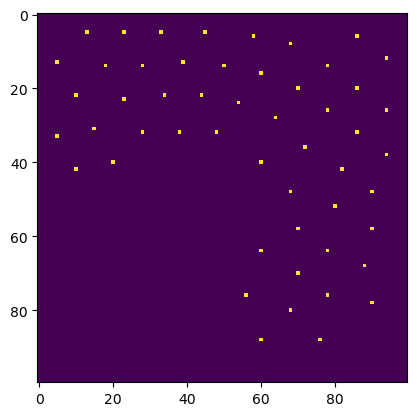

In [16]:
plt.imshow(test.grid)

[75  1]
[6 6]


c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


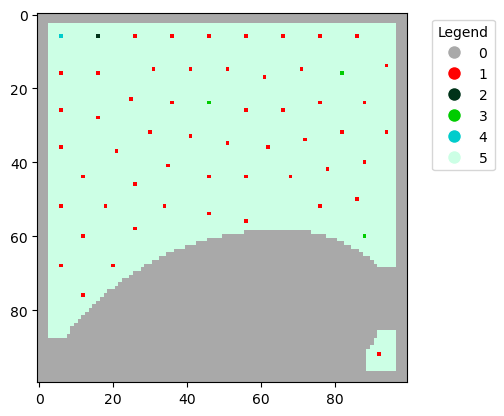

In [2]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = updatedRewardEnv(random.uniform(1,2), 0, 2)
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

In [5]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(octave, theme):
    def _init():
        return updatedRewardEnv(octave, theme)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs = DummyVecEnv([make_env(random.uniform(1,2), 0) for env in range(10)])
envs2 = DummyVecEnv([make_env(random.uniform(1,2), 1) for env in range(10)])

In [3]:
import gc
gc.collect()

3502

In [6]:
from stable_baselines3 import PPO

model = PPO("MlpPolicy", 
             envs, 
             n_steps= 10,
             n_epochs= 10,
             batch_size= 10 * 100,
             verbose=0,
             tensorboard_log="./ppo_spatial_tensorboard/")

c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 1000, but because the `RolloutBuffer` is of size `n_steps * n_envs = 100`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 100
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=10 and n_envs=10)
  warnings.warn(


In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 1000000
total_timesteps = max_runs* 10

model.learn(total_timesteps=total_timesteps, progress_bar=True)
print(evaluate_policy(model, envs, n_eval_episodes=10, warn=False))

In [ ]:
import gc
gc.collect()

In [ ]:
from stable_baselines3 import PPO

model2 = PPO("MlpPolicy", 
             envs2, 
             n_steps= 10,
             n_epochs= 10,
             batch_size= 10 * 100,
             verbose=0,
             tensorboard_log="./ppo_spatial_tensorboard/")

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 1000000
total_timesteps = max_runs* 10

model2.learn(total_timesteps=total_timesteps, progress_bar=True)
print(evaluate_policy(model2, envs2, n_eval_episodes=10, warn=False))

In [4]:
from stable_baselines3 import PPO
model = PPO.load('models/10mil.zip')

c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_make_function' on <module 'cloudpickle.cloudpickle' from 'c:\\Users\\cheng\\anaconda3\\lib\\site-packages\\cloudpickle\\cloudpickle.py'>
  warnings.warn(
c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_make_function' on <module 'cloudpickle.cloudpickle' from 'c:\\Users\\cheng\\anaconda3\\lib\\site-packages\\cloudpickle\\cloudpickle.py'>
  warnings.warn(


42
{0: 0.06976744186046512, 1: 0.5581395348837209, 2: 0.37209302325581395}


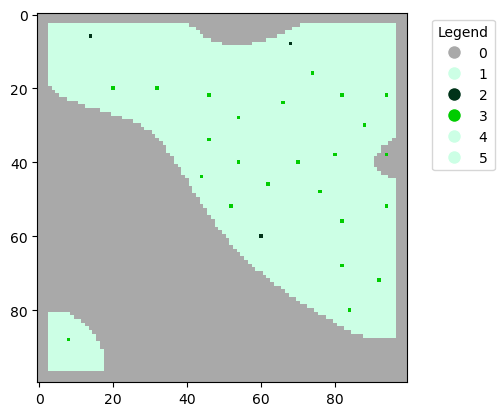

In [36]:
eval_env = updatedRewardEnv(1.25, 0)
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(500):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        # eval_env.render()  
        print(eval_env.class_density)      
        eval_env.render(True)
        break

249
{0: 0.04054054054054054, 1: 0.6756756756756757, 2: 0.28378378378378377}


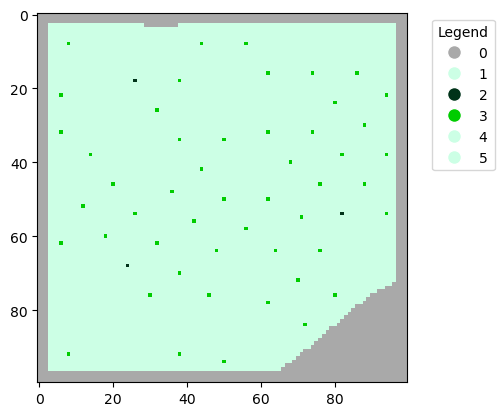

In [37]:
eval_env = updatedRewardEnv(1.25, 1)
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(500):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        print(eval_env.class_density)      
        eval_env.render(True)
        break

In [469]:
model2.save('models/TEST7.zip')

In [470]:
model = model.load('models/TEST6.zip')